In [ ]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.optimizers import Adam


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

# Load Datasets, Cleaning & Preprocessing
The Hourly energy demand, generation, and weather in Spain dataset — containing electrical demand, generation by type, market prices, and weather parameters — was downloaded from Kaggle: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
.

Cleaning includes handling missing values, removing errors, dropping redundant columns, fixing timestamps.

<h3> Energy dataset </h3>

In [313]:
df_energy = pd.read_csv("https://drive.google.com/uc?export=download&id=1nCOuVEdigvbDMqOiuba1JGmtBzxvIHid")

In [314]:
df_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [315]:
df_energy.describe().T

count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

In [316]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [317]:
# columns to be removed due to all 0 or Nan values
col_names = ['generation fossil coal-derived gas', 'generation fossil oil shale','generation fossil peat',
           'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine',
           'generation wind offshore', 'forecast wind offshore eday ahead', 'forecast solar day ahead',
            'forecast wind onshore day ahead']
df_energy = df_energy.drop(col_names, axis = 1)

In [318]:
# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):
    
    print('Number of Nans in each column :')
    
    print(df_input.isnull().sum())
    print()
    print(f'Number of duplicates in the dataframe : {df_input.duplicated().sum()}')
    return

In [319]:
check_Nans_Dups(df_energy)

Number of Nans in each column :
time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Numb

In [320]:
df_energy['time'] = pd.to_datetime(df_energy['time'])
df_energy = df_energy.set_index('time')
df_energy

C:\Users\PREKSHA\AppData\Local\Temp\ipykernel_23224\980508139.py:1: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`



generation biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   
...                                       ...   
2018-12-31 19:00:00+01:00               297.0   
2018-12-31 20:00:00+01:00               296.0   
2018-12-31 21:00:00+01:00               292.0   
2018-12-31 22:00:00+01:00               293.0   
2018-12-31 23:00:00+01:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   
...                                                         ...   
2018-12-31 19:00:00+01:00                                   0.0   
2018-12-31 20:00:00+01:00                                   0.0   
2018-12-31 21:00:00+01:00                                   0.0   
2018-12-31 22:00:00+01:00                                   0.0   
2018-12-31 23:00:00+01:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-01 00:00:00+01:00                 4844.0                       4821.0   
2015-01-01 01:00:00+01:00                 5196.0                       4755.0   
2015-01-01 02:00:00+01:00                 4857.0                       4581.0   
2015-01-01 03:00:00+01:00                 4314.0                       4131.0   
2015-01-01 04:00:00+01:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 19:00:00+01:00                 7634.0                       2628.0   
2018-12-31 20:00:00+01:00                 7241.0                       2566.0   
2018-12-31 21:00:00+01:00                 7025.0                       2422.0   
2018-12-31 22:00:00+01:00                 6562.0                       2293.0   
2018-12-31 23:00:00+01:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2018-12-31 19:00:00+01:00                  178.0   
2018-12-31 20:00:00+01:00                  174.0   
2018-12-31 21:00:00+01:00                  168.0   
2018-12-31 22:00:00+01:00                  163.0   
2018-12-31 23:00:00+01:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2018-12-31 19:00:00+01:00                                          1.0   
2018-12-31 20:00:00+01:00                                          1.0   
2018-12-31 21:00:00+01:00                     

Text(0, 0.5, 'total load actual')

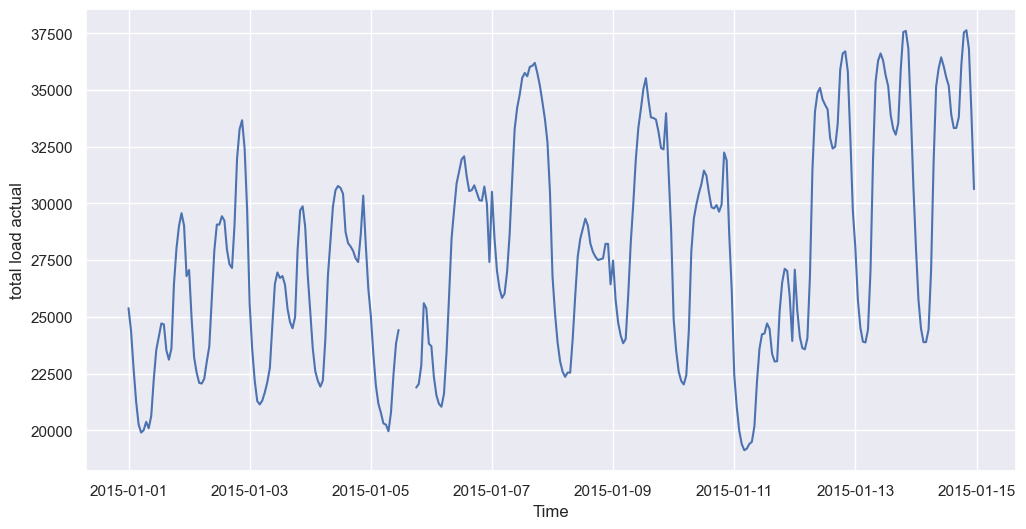

In [321]:
plt.figure(figsize=(12,6))
# plot total load actual for two weeks duration 
plt.plot(df_energy['total load actual'][:24*7*2])
plt.xlabel('Time')
plt.ylabel('total load actual')

In [322]:
# Checking for NaN values
df_energy[df_energy.isna().any(axis = 1)]

generation biomass  \
time                                            
2015-01-05 03:00:00+01:00                 NaN   
2015-01-05 12:00:00+01:00                 NaN   
2015-01-05 13:00:00+01:00                 NaN   
2015-01-05 14:00:00+01:00                 NaN   
2015-01-05 15:00:00+01:00                 NaN   
2015-01-05 16:00:00+01:00                 NaN   
2015-01-05 17:00:00+01:00                 NaN   
2015-01-19 19:00:00+01:00                 NaN   
2015-01-19 20:00:00+01:00                 NaN   
2015-01-27 19:00:00+01:00                 NaN   
2015-01-28 13:00:00+01:00                 NaN   
2015-02-01 07:00:00+01:00               449.0   
2015-02-01 08:00:00+01:00               453.0   
2015-02-01 09:00:00+01:00               452.0   
2015-02-01 12:00:00+01:00               405.0   
2015-02-01 13:00:00+01:00               402.0   
2015-02-01 14:00:00+01:00               400.0   
2015-02-01 15:00:00+01:00               393.0   
2015-02-01 16:00:00+01:00               413.0   
2015-02-01 17:00:00+01:00               465.0   
2015-02-01 18:00:00+01:00               482.0   
2015-02-01 19:00:00+01:00               474.0   
2015-04-05 03:00:00+02:00               371.0   
2015-04-16 09:00:00+02:00                 NaN   
2015-04-20 08:00:00+02:00               424.0   
2015-04-23 21:00:00+02:00                 NaN   
2015-05-02 10:00:00+02:00               497.0   
2015-05-29 03:00:00+02:00               569.0   
2015-06-15 09:00:00+02:00                 NaN   
2015-10-02 08:00:00+02:00               483.0   
2015-10-02 11:00:00+02:00                 NaN   
2015-12-02 09:00:00+01:00                 NaN   
2016-04-13 05:00:00+02:00               220.0   
2016-04-25 05:00:00+02:00               190.0   
2016-04-25 07:00:00+02:00               206.0   
2016-05-10 23:00:00+02:00               348.0   
2016-06-12 01:00:00+02:00               356.0   
2016-07-09 22:00:00+02:00                 NaN   
2016-07-12 00:00:00+02:00               346.0   
2016-09-28 09:00:00+02:00               347.0   
2016-10-27 23:00:00+02:00               351.0   
2016-11-23 04:00:00+01:00                 NaN   
2017-11-14 12:00:00+01:00                 0.0   
2017-11-14 19:00:00+01:00                 0.0   
2018-06-11 18:00:00+02:00               331.0   
2018-07-11 09:00:00+02:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-05 03:00:00+01:00                                   NaN   
2015-01-05 12:00:00+01:00                                   NaN   
2015-01-05 13:00:00+01:00                                   NaN   
2015-01-05 14:00:00+01:00                                   NaN   
2015-01-05 15:00:00+01:00                                   NaN   
2015-01-05 16:00:00+01:00                                   NaN   
2015-01-05 17:00:00+01:00                                   NaN   
2015-01-19 19:00:00+01:00                                   NaN   
2015-01-19 20:00:00+01:00                                   NaN   
2015-01-27 19:00:00+01:00                                   NaN   
2015-01-28 13:00:00+01:00                                   NaN   
2015-02-01 07:00:00+01:00                                 312.0   
2015-02-01 08:00:00+01:00                                 312.0   
2015-02-01 09:00:00+01:00                                 302.0   
2015-02-01 12:00:00+01:00                                 317.0   
2015-02-01 13:00:00+01:00                                 317.0   
2015-02-01 14:00:00+01:00                                 317.0   
2015-02-01 15:00:00+01:00                                 321.0   
2015-02-01 16:00:00+01:00                                 325.0   
2015-02-01 17:00:00+01:00                                 321.0   
2015-02-01 18:00:00+01:00                                 326.0   
2015-02-01 19:00:00+01:00                                 326.0   
2015-04-05 03:00:00+02:00                                   0.0   

In [323]:
# Filling them by linear interpolation
df_energy.interpolate(method='linear', limit_direction='forward', inplace = True)

In [324]:
# Confirming NaN values are gone
df_energy.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

In [325]:
# Combining all fossil fuels (different types of coal)
df_energy["generation fossil total"] = df_energy['generation fossil hard coal'] + df_energy['generation fossil brown coal/lignite']
df_energy.drop(['generation fossil hard coal', 'generation fossil brown coal/lignite'], axis = 1, inplace = True)

In [326]:
# Plotting correlation heatmap
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    
    return plt.show()

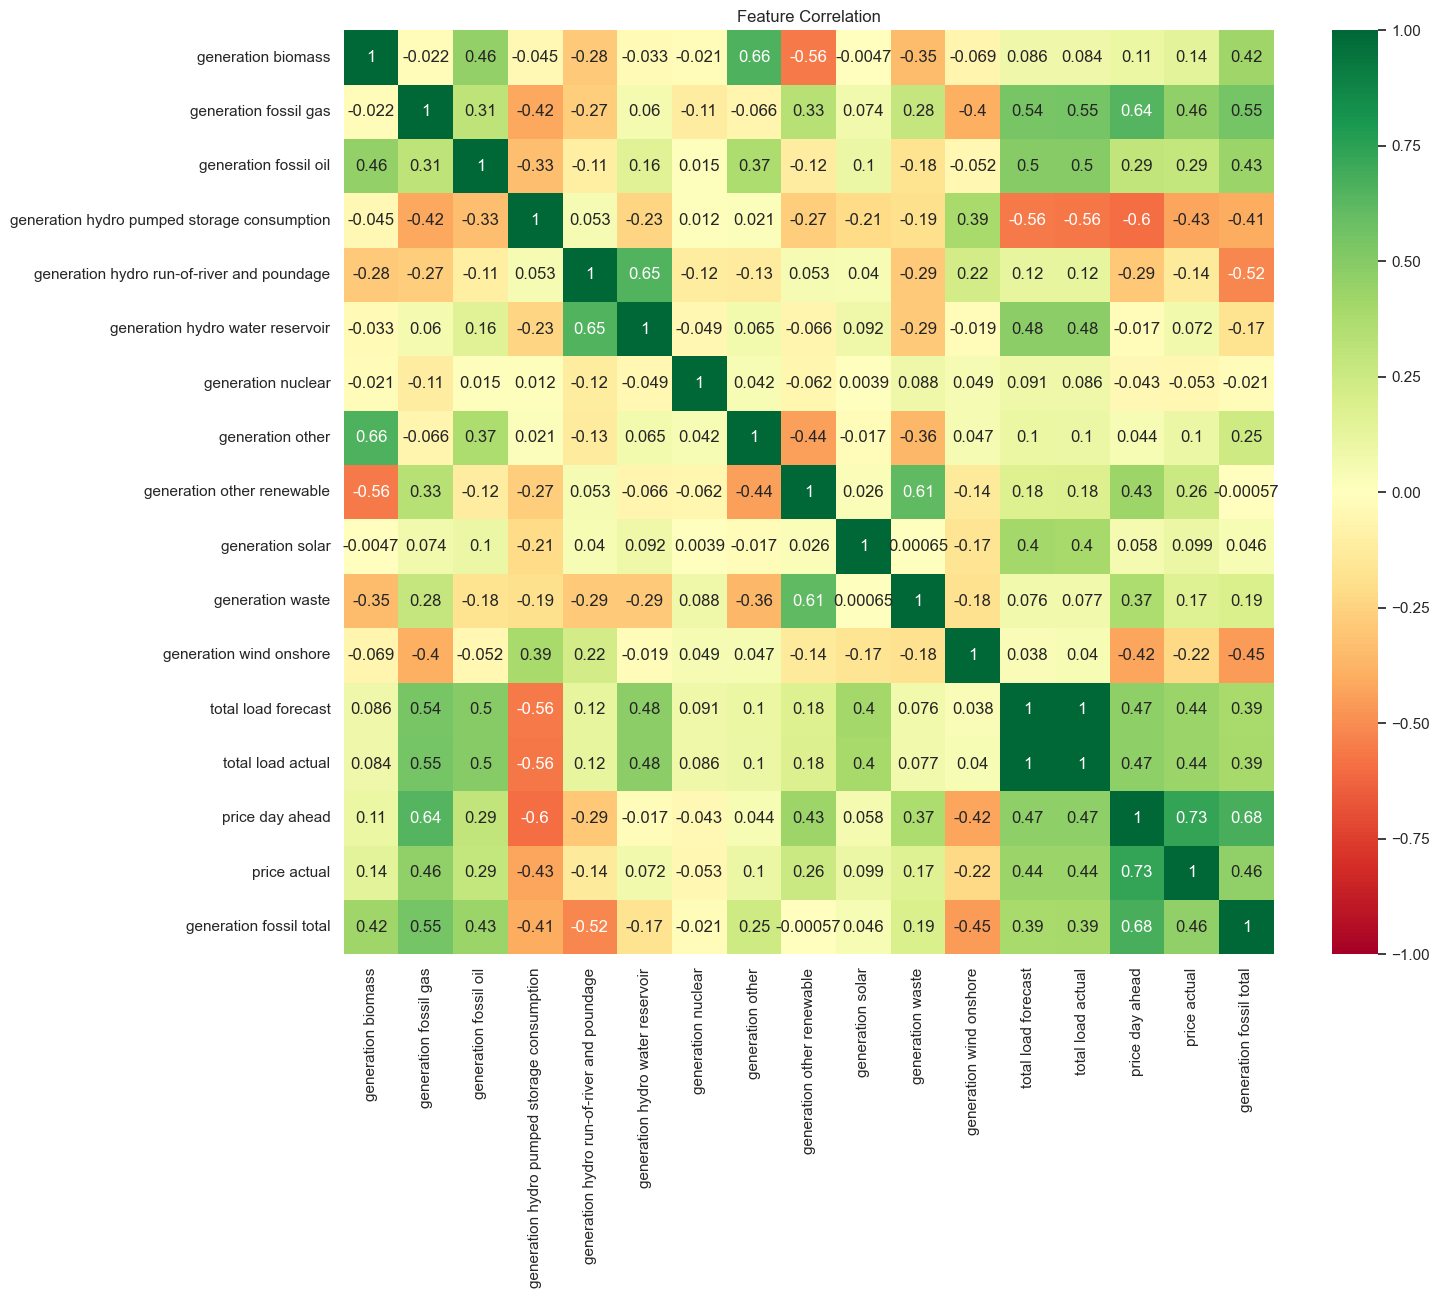

In [327]:
feat_corr(df_energy)

<h3> Weather dataset </h3>

In [328]:
df_weather = pd.read_csv(r"C:\Users\PREKSHA\Desktop\ESL372\Project\weather_features.csv")

In [329]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [330]:
df_weather.describe().T

count         mean          std     min          25%      50%  \
temp        178396.0   289.618605     8.026199  262.24   283.670000   289.15   
temp_min    178396.0   288.330442     7.955491  262.24   282.483602   288.15   
temp_max    178396.0   291.091267     8.612454  262.24   284.650000   290.15   
pressure    178396.0  1069.260740  5969.631893    0.00  1013.000000  1018.00   
humidity    178396.0    68.423457    21.902888    0.00    53.000000    72.00   
wind_speed  178396.0     2.470560     2.095910    0.00     1.000000     2.00   
wind_deg    178396.0   166.591190   116.611927    0.00    55.000000   177.00   
rain_1h     178396.0     0.075492     0.398847    0.00     0.000000     0.00   
rain_3h     178396.0     0.000380     0.007288    0.00     0.000000     0.00   
snow_3h     178396.0     0.004763     0.222604    0.00     0.000000     0.00   
clouds_all  178396.0    25.073292    30.774129    0.00     0.000000    20.00   
weather_id  178396.0   759.831902   108.733223  200.00   800.000000   800.00   

                    75%          max  
temp         295.150000      315.600  
temp_min     293.730125      315.150  
temp_max     297.150000      321.150  
pressure    1022.000000  1008371.000  
humidity      87.000000      100.000  
wind_speed     4.000000      133.000  
wind_deg     270.000000      360.000  
rain_1h        0.000000       12.000  
rain_3h        0.000000        2.315  
snow_3h        0.000000       21.500  
clouds_all    40.000000      100.000  
weather_id   801.000000      804.000

In [331]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [332]:
# Copying the weather dataframe and converts selected categorical weather columns into numeric codes using Label Encoding 
# Eg: for weather_main column, "Clear" = 0, "Cloudy" = 1, "Rainy" = 2
df_temp = df_weather.copy(deep = True)
labels = ['weather_id', 'weather_main','weather_description','weather_icon']
for col in labels:
    df_temp[col] = LabelEncoder().fit_transform(df_weather[col])

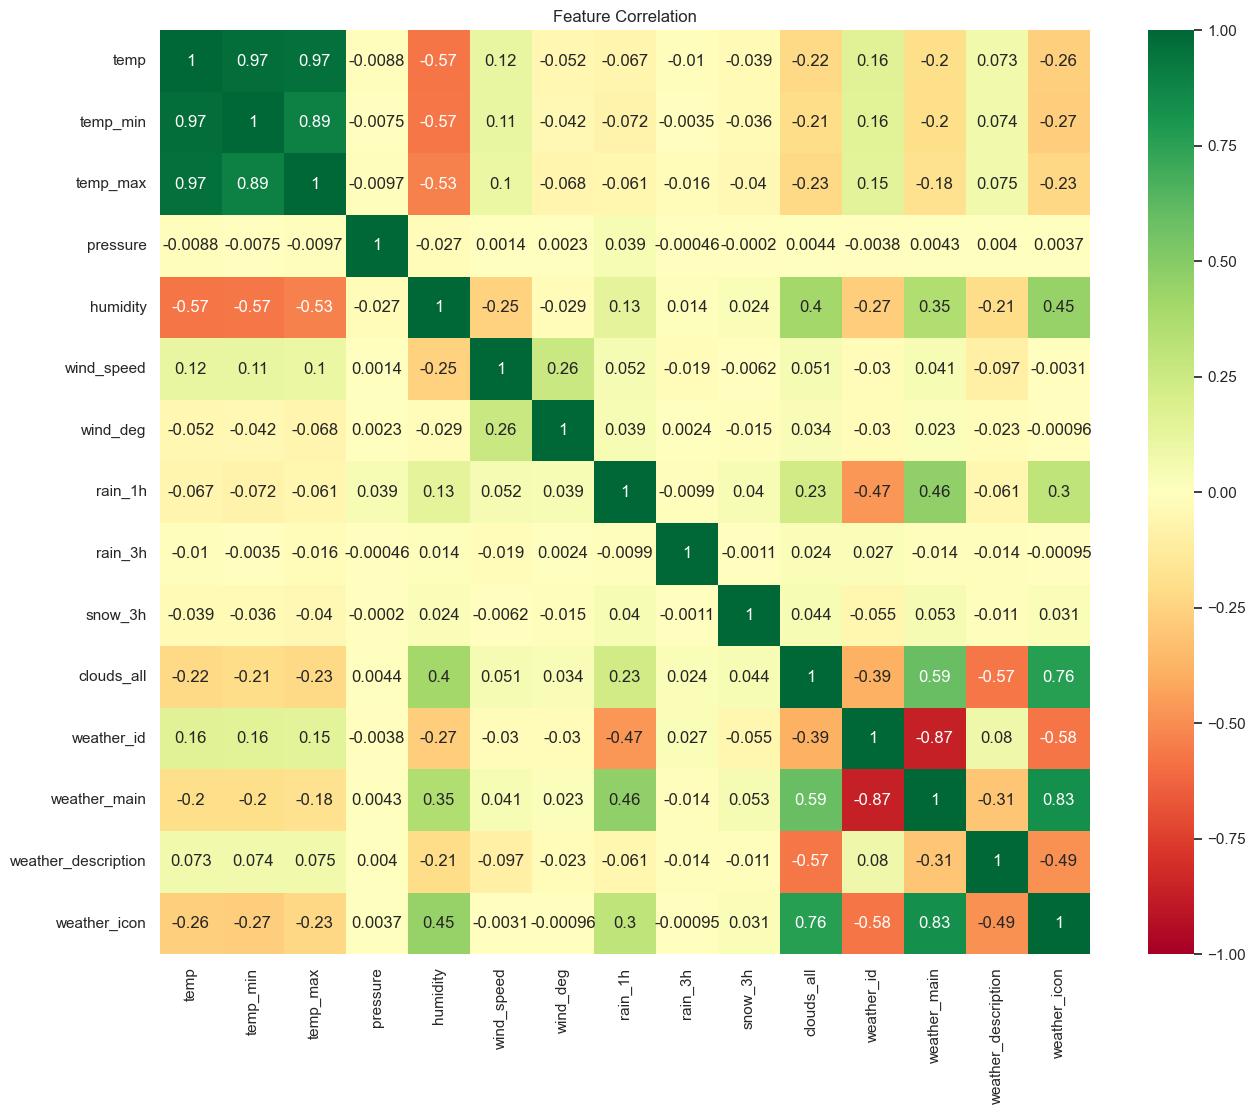

In [333]:
# Only keeping the numeric columns in df_temp and plotting correlation heatmap
df_temp = df_temp.select_dtypes(include=[np.number])
feat_corr(df_temp)

In [334]:
df_weather['weather_id'].unique()

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

In [335]:
# Removing unused weather and temperature columns, cleaning duplicates
col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon', 'temp_min', 'temp_max']
df_weather.drop(col_drop_name, axis = 1 , inplace = True)

In [336]:
check_Nans_Dups(df_weather)

Number of Nans in each column :
dt_iso        0
city_name     0
temp          0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
dtype: int64

Number of duplicates in the dataframe : 3076


In [337]:
df_weather = df_weather.reset_index().drop_duplicates()

In [338]:
# Converting the timestamp to datetime, and sets it as the dataframe index
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'])
df_weather.drop(["dt_iso"] , axis = 1, inplace = True)
df_weather = df_weather.set_index('time')
df_weather.drop(["index"] , axis = 1, inplace = True)

C:\Users\PREKSHA\AppData\Local\Temp\ipykernel_23224\778726426.py:2: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`



In [339]:
df_weather.head()

city_name     temp  pressure  humidity  wind_speed  \
time                                                                           
2015-01-01 00:00:00+01:00  Valencia  270.475      1001        77           1   
2015-01-01 01:00:00+01:00  Valencia  270.475      1001        77           1   
2015-01-01 02:00:00+01:00  Valencia  269.686      1002        78           0   
2015-01-01 03:00:00+01:00  Valencia  269.686      1002        78           0   
2015-01-01 04:00:00+01:00  Valencia  269.686      1002        78           0   

                           wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  
time                                                                        
2015-01-01 00:00:00+01:00        62      0.0      0.0      0.0           0  
2015-01-01 01:00:00+01:00        62      0.0      0.0      0.0           0  
2015-01-01 02:00:00+01:00        23      0.0      0.0      0.0           0  
2015-01-01 03:00:00+01:00        23      0.0      0.0      0.0           0  
2015-01-01 04:00:00+01:00        23      0.0      0.0      0.0           0

In [340]:
df_energy.head()

generation biomass  generation fossil gas  \
time                                                                   
2015-01-01 00:00:00+01:00               447.0                 4844.0   
2015-01-01 01:00:00+01:00               449.0                 5196.0   
2015-01-01 02:00:00+01:00               448.0                 4857.0   
2015-01-01 03:00:00+01:00               438.0                 4314.0   
2015-01-01 04:00:00+01:00               428.0                 4130.0   

                           generation fossil oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   

                           generation hydro run-of-river and poundage  \
time                                                                    
2015-01-01 00:00:00+01:00                                      1051.0   
2015-01-01 01:00:00+01:00                                      1009.0   
2015-01-01 02:00:00+01:00                                       973.0   
2015-01-01 03:00:00+01:00                                       949.0   
2015-01-01 04:00:00+01:00                                       953.0   

                           generation hydro water reservoir  \
time                                                          
2015-01-01 00:00:00+01:00                            1899.0   
2015-01-01 01:00:00+01:00                            1658.0   
2015-01-01 02:00:00+01:00                            1371.0   
2015-01-01 03:00:00+01:00                             779.0   
2015-01-01 04:00:00+01:00                             720.0   

                           generation nuclear  generation other  \
time                                                              
2015-01-01 00:00:00+01:00              7096.0              43.0   
2015-01-01 01:00:00+01:00              7096.0              43.0   
2015-01-01 02:00:00+01:00              7099.0              43.0   
2015-01-01 03:00:00+01:00              7098.0              43.0   
2015-01-01 04:00:00+01:00              7097.0              43.0   

                           generation other renewable  generation solar  \
time                                                                      
2015-01-01 00:00:00+01:00                        73.0              49.0   
2015-01-01 01:00:00+01:00                        71.0              50.0   
2015-01-01 02:00:00+01:00                        73.0              50.0   
2015-01-01 03:00:00+01:00                        75.0              50.0   
2015-01-01 04:00:00+01:00                        74.0              42.0   

                           generation waste  generation wind onshore  \
time                                                                   
2015-01-01 00:00:00+01:00             196.0                   6378.0   
2015-01-01 01:00:00+01:00             195.0                   5890.0   
2015-01-01 02:00:00+01:00             196.0                   5461.0   
2015-01-01 03:00:00+01:00             191.0                   5238.0   
2015-01-01 04:00:00+01:00             189.0                   4935.0   

                           total load forecast  total load actual  \
time                                                                
2015-01-01 00:00:00+01:00              26118.

In [341]:
df_weather.describe().round(2)

temp    pressure   humidity  wind_speed   wind_deg    rain_1h  \
count  178396.00   178396.00  178396.00   178396.00  178396.00  178396.00   
mean      289.62     1069.26      68.42        2.47     166.59       0.08   
std         8.03     5969.63      21.90        2.10     116.61       0.40   
min       262.24        0.00       0.00        0.00       0.00       0.00   
25%       283.67     1013.00      53.00        1.00      55.00       0.00   
50%       289.15     1018.00      72.00        2.00     177.00       0.00   
75%       295.15     1022.00      87.00        4.00     270.00       0.00   
max       315.60  1008371.00     100.00      133.00     360.00      12.00   

         rain_3h    snow_3h  clouds_all  
count  178396.00  178396.00   178396.00  
mean        0.00       0.00       25.07  
std         0.01       0.22       30.77  
min         0.00       0.00        0.00  
25%         0.00       0.00        0.00  
50%         0.00       0.00       20.00  
75%         0.00       0.00       40.00  
max         2.32      21.50      100.00

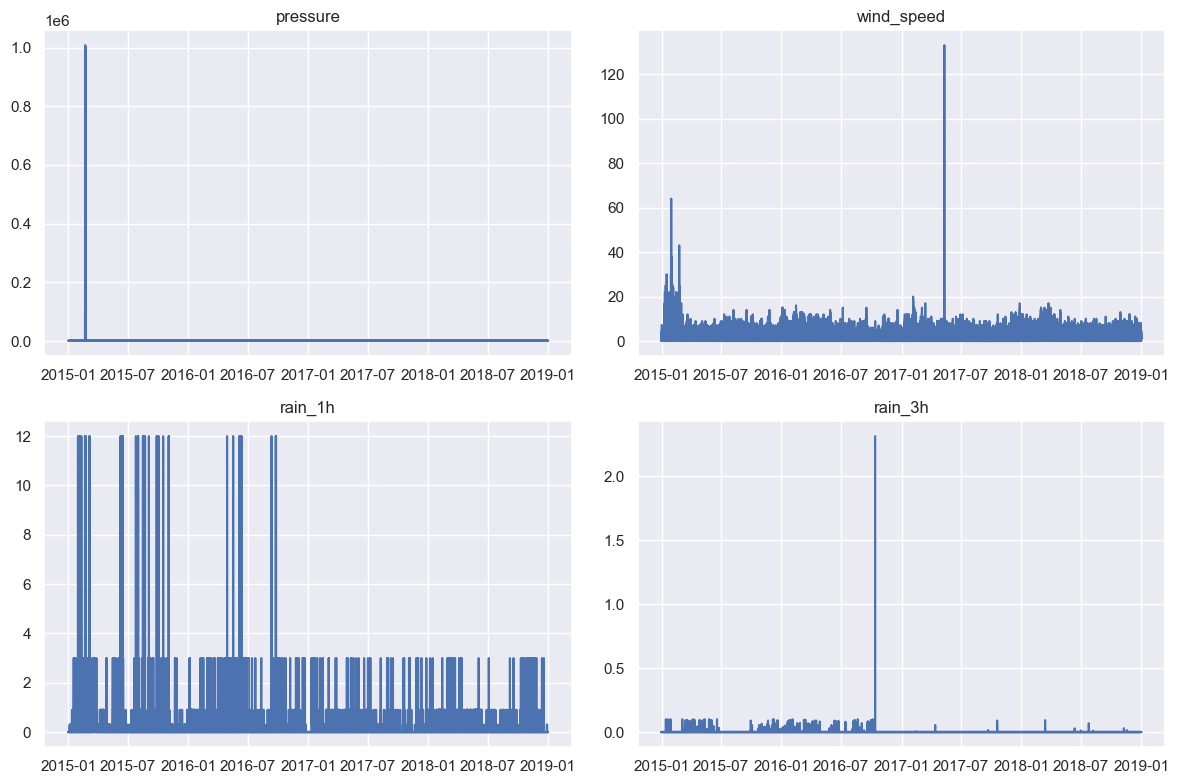

In [342]:
# Plotting pressure, wind speed, rain_1h and rain3h for the available timeseries
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.plot(df_weather.index, df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  
plt.show() 

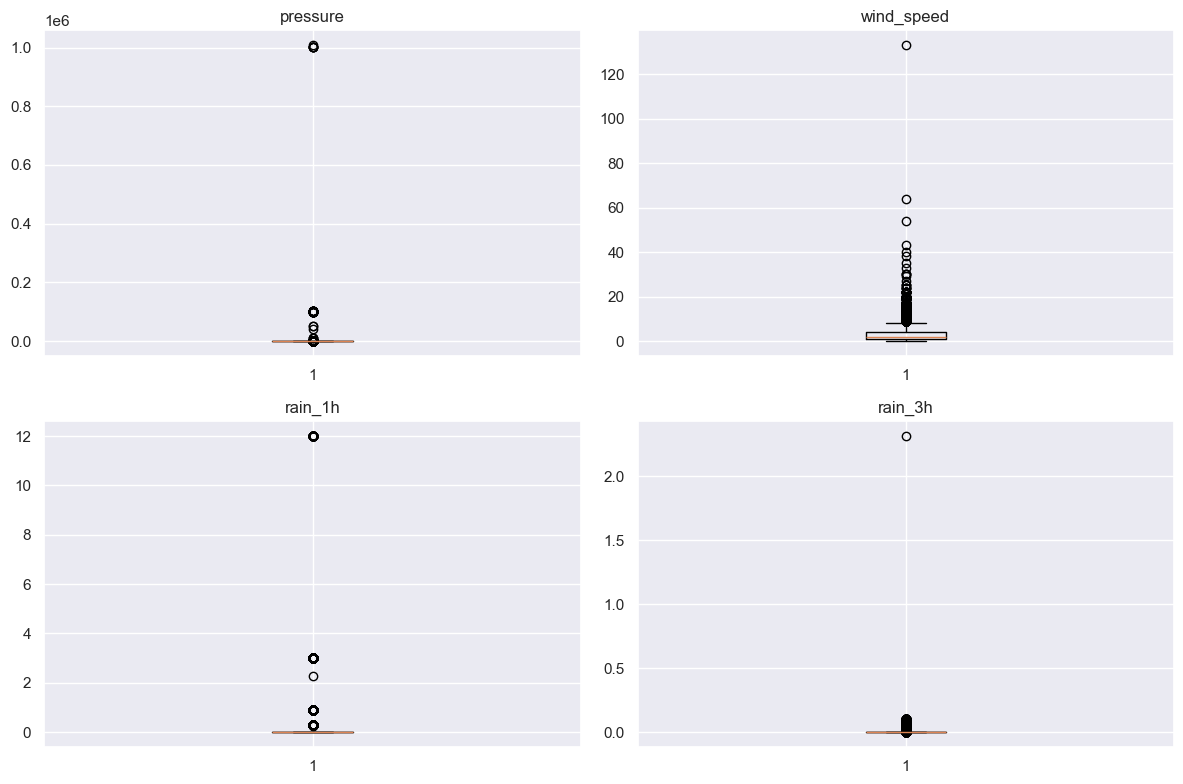

In [343]:
# Plotting boxplots to visually compare the distributions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout() 
plt.show()

In [344]:
# Replacing unrealistic outliers with interpolated values
df_weather.loc[df_weather['pressure']  > 1080,  'pressure'] = np.nan
df_weather.loc[df_weather['pressure']   < 870,  'pressure'] = np.nan
df_weather.loc[df_weather['wind_speed'] > 113, 'wind_speed'] = np.nan

df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)

C:\Users\PREKSHA\AppData\Local\Temp\ipykernel_23224\1238158245.py:6: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



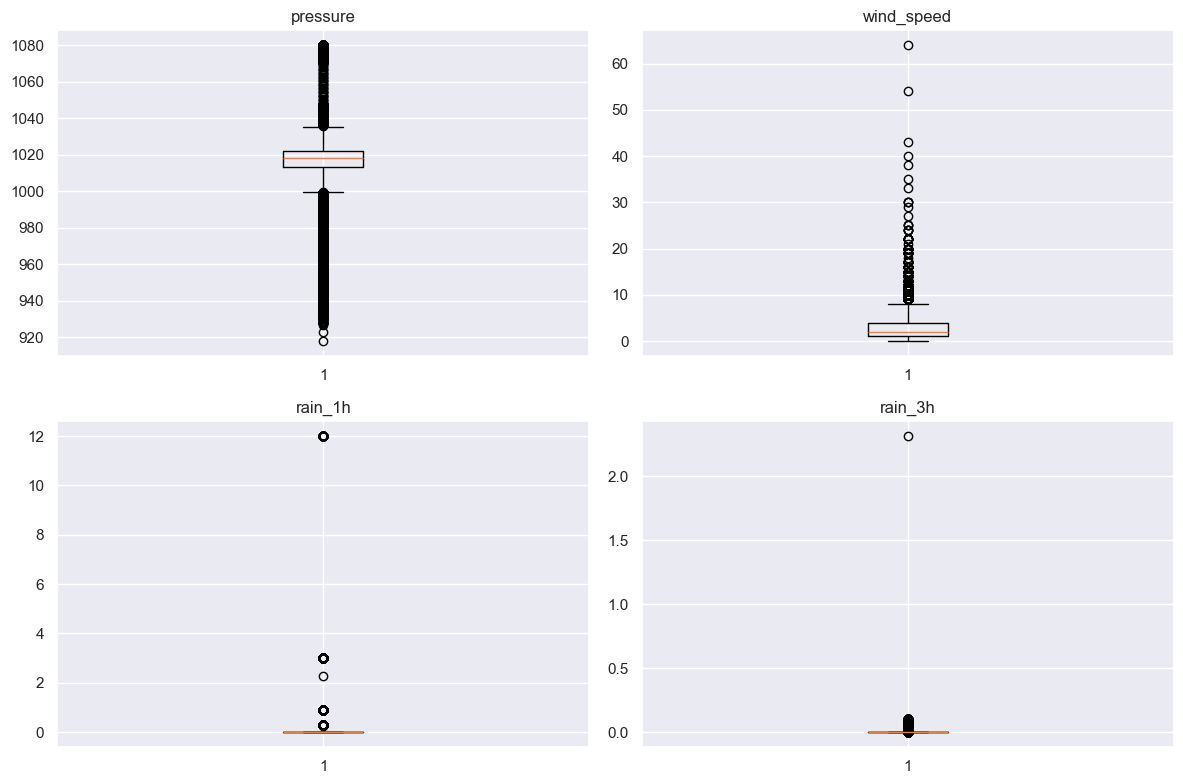

In [345]:

# Plotting the boxplots again
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout() 
plt.show() 

In [346]:
# Dropping rain_h3 since it is almost always zero
df_weather.drop(['rain_3h'], axis = 1 , inplace = True)

In [347]:
# How many rows are in the energy dataset and number of weather data samples for each city

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_weather in Valencia is 35145
Number of samples in df_weather in Madrid is 36267
Number of samples in df_weather in Bilbao is 35951
Number of samples in df_weather in  Barcelona is 35476
Number of samples in df_weather in Seville is 35557


In [348]:

# Removing duplicate weather records that share the same timestamp and city
df_weather_cleaned = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [349]:
df_weather_cleaned.head()

city_name     temp  pressure  humidity  wind_speed  \
time                                                                           
2015-01-01 00:00:00+01:00  Valencia  270.475    1001.0        77         1.0   
2015-01-01 01:00:00+01:00  Valencia  270.475    1001.0        77         1.0   
2015-01-01 02:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
2015-01-01 03:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
2015-01-01 04:00:00+01:00  Valencia  269.686    1002.0        78         0.0   

                           wind_deg  rain_1h  snow_3h  clouds_all  
time                                                               
2015-01-01 00:00:00+01:00        62      0.0      0.0           0  
2015-01-01 01:00:00+01:00        62      0.0      0.0           0  
2015-01-01 02:00:00+01:00        23      0.0      0.0           0  
2015-01-01 03:00:00+01:00        23      0.0      0.0           0  
2015-01-01 04:00:00+01:00        23      0.0      0.0           0

In [350]:
# Each city now has exactly one weather record per timestamp
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather_cleaned.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35064
Number of samples in df_weather in Valencia is 35064
Number of samples in df_weather in Madrid is 35064
Number of samples in df_weather in Bilbao is 35064
Number of samples in df_weather in  Barcelona is 35064
Number of samples in df_weather in Seville is 35064


In [351]:
# Creating a list where each element is the weather dataframe for one city
df_weather_all_cities = [grouped_weather.get_group(x) for x in grouped_weather.groups]

In [352]:
df_weather_all_cities[0].head()  # all Barcelona entries

city_name     temp  pressure  humidity  \
time                                                                 
2015-01-01 00:00:00+01:00   Barcelona  281.625    1035.0       100   
2015-01-01 01:00:00+01:00   Barcelona  281.625    1035.0       100   
2015-01-01 02:00:00+01:00   Barcelona  281.286    1036.0       100   
2015-01-01 03:00:00+01:00   Barcelona  281.286    1036.0       100   
2015-01-01 04:00:00+01:00   Barcelona  281.286    1036.0       100   

                           wind_speed  wind_deg  rain_1h  snow_3h  clouds_all  
time                                                                           
2015-01-01 00:00:00+01:00         7.0        58      0.0      0.0           0  
2015-01-01 01:00:00+01:00         7.0        58      0.0      0.0           0  
2015-01-01 02:00:00+01:00         7.0        48      0.0      0.0           0  
2015-01-01 03:00:00+01:00         7.0        48      0.0      0.0           0  
2015-01-01 04:00:00+01:00         7.0        48      0.0      0.0           0

# Feature Engineering & Data Merging

Create time features, merge city weather with energy data, encode cyclic patterns.

In [353]:
# Merging the weather data of each city into the energy dataframe by adding city-specific suffixes to the weather columns, concatenating them side-by-side, and then removing the duplicated city name column.
df_weather_energy = df_energy

for df_city in df_weather_all_cities:
    city_name = df_city.iloc[0]['city_name'].replace(' ', '')
    df_temp_city = df_city.add_suffix(f'_{city_name}')
    df_weather_energy = pd.concat([df_weather_energy, df_temp_city], axis=1)
    df_weather_energy = df_weather_energy.drop(f'city_name_{city_name}' , axis=1)

In [354]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madri

In [355]:
check_Nans_Dups(df_weather_energy)

Number of Nans in each column :
generation biomass                             0
generation fossil gas                          0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
generation fossil total                        0
temp_Barcelona                                 0
pressure_Barcelona                             0
humidity_Barcelona                   

In [356]:
# Extracting time-based features from the datetime index (hour, weekday, month, year) and aaddingdds them as new columns to help capture temporal patterns in the data.
df_weather_energy['hour'] = df_weather_energy.index.map(lambda x : x.hour)
df_weather_energy['weekday'] = df_weather_energy.index.map(lambda x : x.weekday())
df_weather_energy['month'] = df_weather_energy.index.map(lambda x : x.month)
df_weather_energy['year'] = df_weather_energy.index.map(lambda x: x.year)

In [357]:
# adds two extra features: a temperature change rate (temp_gradient) and cyclical encodings of hour (hour_sin, hour_cos) so the model can learn daily patterns without treating hours as linear numbers.
if 'temp' in df_weather_energy.columns:
    df_weather_energy["temp_gradient"] = df_weather_energy["temp"].diff().fillna(0)

df_weather_energy["hour_sin"] = np.sin(2 * np.pi * df_weather_energy["hour"] / 24)
df_weather_energy["hour_cos"] = np.cos(2 * np.pi * df_weather_energy["hour"] / 24)


In [358]:
df_weather_energy.head()

generation biomass  generation fossil gas  \
time                                                                   
2015-01-01 00:00:00+01:00               447.0                 4844.0   
2015-01-01 01:00:00+01:00               449.0                 5196.0   
2015-01-01 02:00:00+01:00               448.0                 4857.0   
2015-01-01 03:00:00+01:00               438.0                 4314.0   
2015-01-01 04:00:00+01:00               428.0                 4130.0   

                           generation fossil oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   

                           generation hydro run-of-river and poundage  \
time                                                                    
2015-01-01 00:00:00+01:00                                      1051.0   
2015-01-01 01:00:00+01:00                                      1009.0   
2015-01-01 02:00:00+01:00                                       973.0   
2015-01-01 03:00:00+01:00                                       949.0   
2015-01-01 04:00:00+01:00                                       953.0   

                           generation hydro water reservoir  \
time                                                          
2015-01-01 00:00:00+01:00                            1899.0   
2015-01-01 01:00:00+01:00                            1658.0   
2015-01-01 02:00:00+01:00                            1371.0   
2015-01-01 03:00:00+01:00                             779.0   
2015-01-01 04:00:00+01:00                             720.0   

                           generation nuclear  generation other  \
time                                                              
2015-01-01 00:00:00+01:00              7096.0              43.0   
2015-01-01 01:00:00+01:00              7096.0              43.0   
2015-01-01 02:00:00+01:00              7099.0              43.0   
2015-01-01 03:00:00+01:00              7098.0              43.0   
2015-01-01 04:00:00+01:00              7097.0              43.0   

                           generation other renewable  generation solar  ...  \
time                                                                     ...   
2015-01-01 00:00:00+01:00                        73.0              49.0  ...   
2015-01-01 01:00:00+01:00                        71.0              50.0  ...   
2015-01-01 02:00:00+01:00                        73.0              50.0  ...   
2015-01-01 03:00:00+01:00                        75.0              50.0  ...   
2015-01-01 04:00:00+01:00                        74.0              42.0  ...   

                           wind_deg_Valencia  rain_1h_Valencia  \
time                                                             
2015-01-01 00:00:00+01:00                 62               0.0   
2015-01-01 01:00:00+01:00                 62               0.0   
2015-01-01 02:00:00+01:00                 23               0.0   
2015-01-01 03:00:00+01:00                 23               0.0   
2015-01-01 04:00:00+01:00                 23               0.0   

                           snow_3h_Valencia  clouds_all_Valencia  hour  \
time                                                                     
2015-01-01 00:00:00+01:00               0.

# Exploratory Data Analysis & Time-Series Understanding

Visualizations + statistical diagnostics.

In [359]:
# Plotting the actual electricity price over time along with its 24-hour (daily) and 168-hour (weekly) rolling averages to visualize short- and long-term price trends.
fig = make_subplots()

fig.add_trace(
    go.Scatter(x=df_weather_energy.index, y=df_weather_energy["price actual"],
                                name="price actual"))
fig.add_trace(
    go.Scatter(x=df_weather_energy.index,y=df_weather_energy.rolling(window=24).mean()["price actual"],
                                        name="rolling window = daily ave"))
fig.add_trace(
    go.Scatter(x=df_weather_energy.index,y=df_weather_energy.rolling(window=24*7).mean()["price actual"],
                                        name="rolling window = weekly ave"))

fig.show()

Text(0.5, 1.0, 'Daily actual price (0 is Monday)')

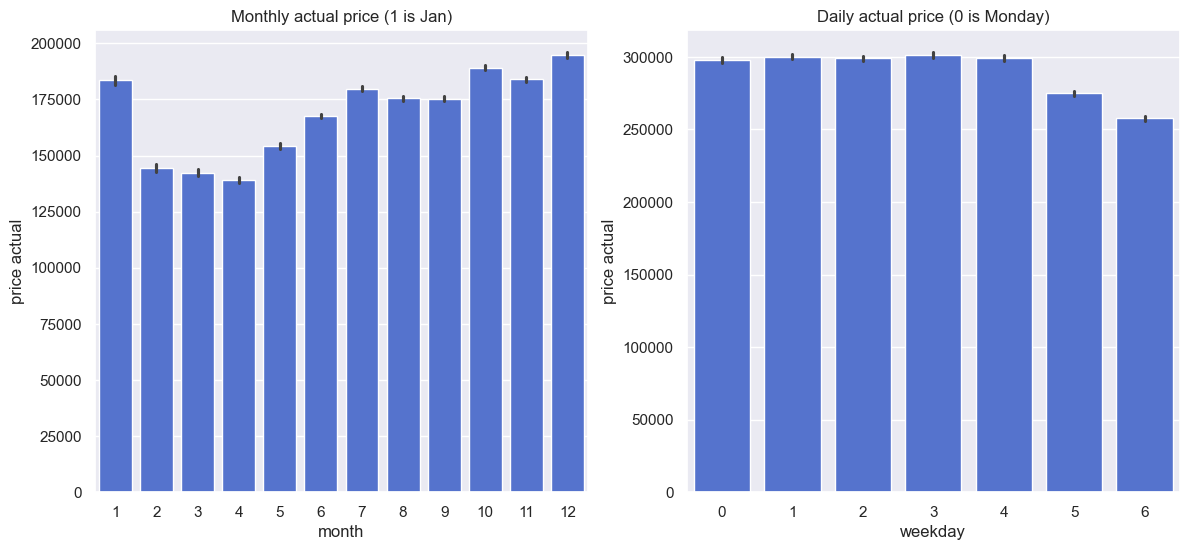

In [360]:
# Creating two barplots showing how the total electricity price varies across months and weekdays, helping reveal seasonal and weekly demand–price patterns.
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.set(style="darkgrid")

sns.barplot(
    x="month", 
    y="price actual", 
    data=df_weather_energy, 
    estimator=sum, 
    color='royalblue',
    ax=axes[0]);
axes[0].set_title('Monthly actual price (1 is Jan)')

sns.barplot(
    x="weekday", 
    y="price actual", 
    data=df_weather_energy, 
    estimator=sum, 
    color='royalblue',
    ax=axes[1]);
axes[1].set_title('Daily actual price (0 is Monday)')


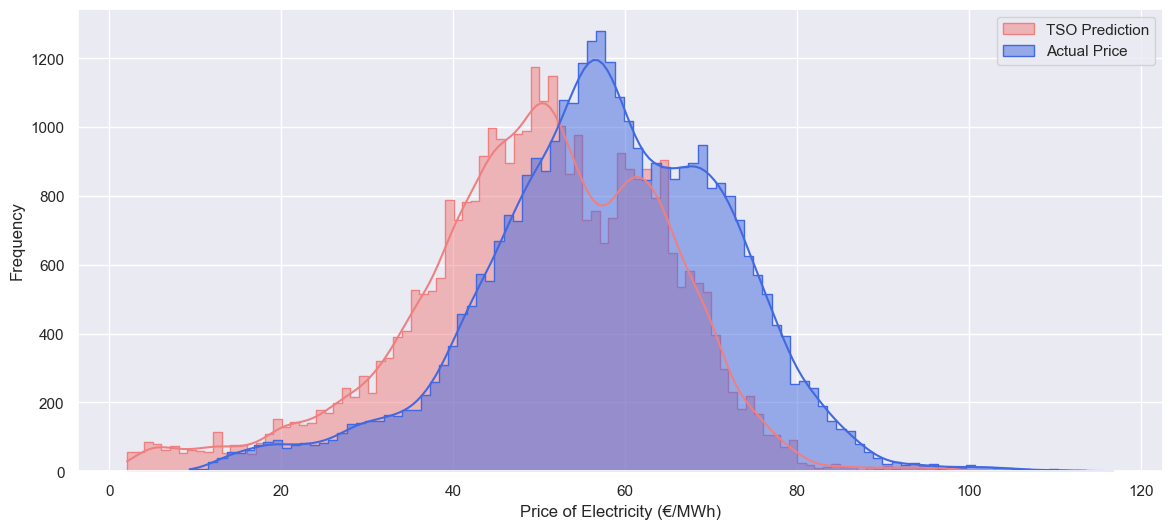

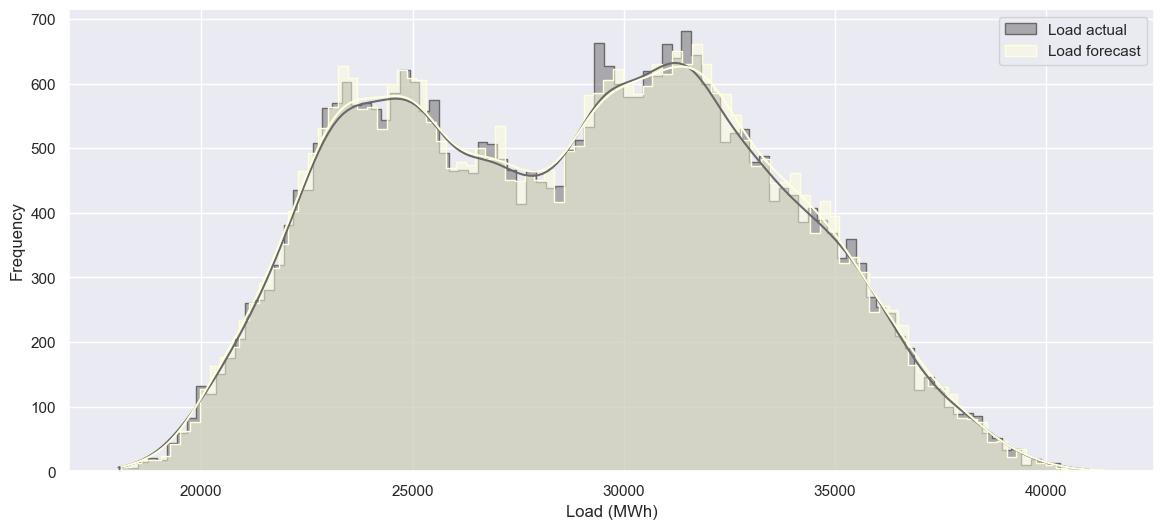

In [361]:
# These plots compare the distributions of forecasted vs. actual electricity price and load
plt.figure(figsize=(14,6))

gr = sns.histplot(df_weather_energy['price day ahead'], bins=100, label='TSO Prediction', element="step", color='lightcoral', kde = True)
gr = sns.histplot(df_weather_energy['price actual'], bins=100, label='Actual Price', element="step", color='royalblue', kde = True)


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
gr = sns.histplot(df_weather_energy['total load actual'], bins=100, label='Load actual', element="step", color='dimgrey', kde = True)
gr = sns.histplot(df_weather_energy['total load forecast'], bins=100, label='Load forecast', element="step", color='lightyellow', kde = True)

gr.set(xlabel="Load (MWh)", ylabel="Frequency")
plt.legend()
plt.show()

In [362]:
# Scaling the actual and day-ahead price values separately using Min-Max scaling on the training portion of the data, then computing the mean absolute error between the two normalized price series.
y_scaler_actual = MinMaxScaler()
y_scaler_dayahead = MinMaxScaler()

train_cutoff = int(0.8*df_weather_energy.shape[0])
val_cutoff = int(0.9*df_weather_energy.shape[0])

y_price_actual   = df_weather_energy[['price actual']]
y_price_dayahead = df_weather_energy[['price day ahead']]

y_scaler_actual.fit(y_price_actual[:train_cutoff])
actual_norm = y_scaler_actual.transform(y_price_actual)

y_scaler_dayahead.fit(df_weather_energy[['price day ahead']][:train_cutoff])
dayahead_norm = y_scaler_dayahead.transform(y_price_dayahead)

print(f' mean absolute error for normalized acutal price and TSO predcition is : {round(mean_absolute_error(actual_norm, dayahead_norm),3)}')

 mean absolute error for normalized acutal price and TSO predcition is : 0.071


In [363]:
# Since the day-ahead price already predicts the actual price with very low error (≈7%), the forecasted load adds no new info.
df_weather_energy.drop(['total load forecast'], axis = 1, inplace = True)

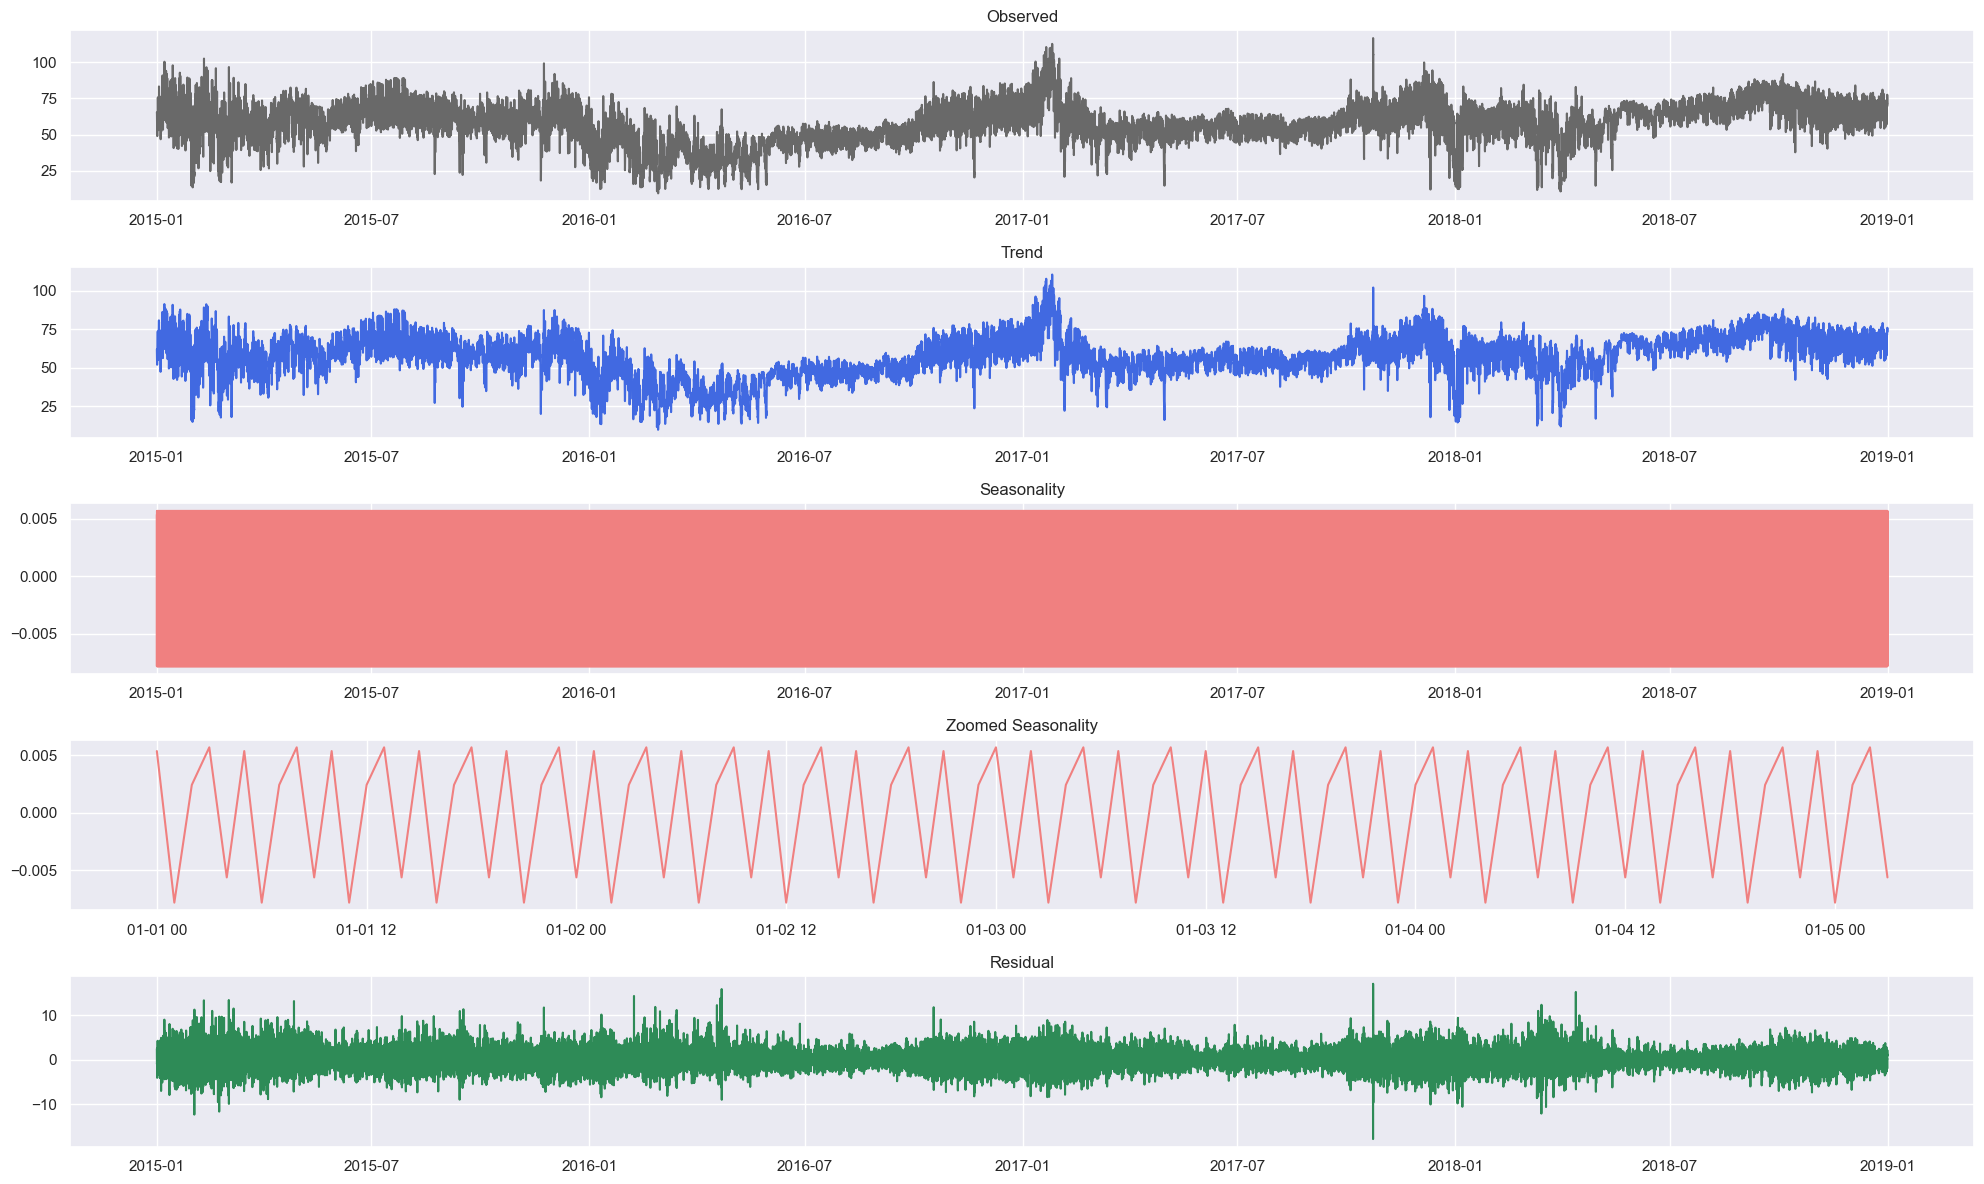

In [364]:
# Performing a seasonal decomposition of the actual electricity price into observed, trend, seasonal, and residual components (assuming a 5-step repeating pattern) and plots each to show how much of the price variation comes from long-term trend vs. short-term seasonality vs. noise.
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = df_weather_energy[['price actual']].copy()

decompose_result = seasonal_decompose(decom_data, period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(seasonal[:100], color='lightcoral')
axes[3].set_title('Zoomed Seasonality')
axes[4].plot(residual, color='seagreen')
axes[4].set_title('Residual')

fig.tight_layout()
plt.show()


In [365]:
# Running the Augmented Dickey–Fuller test on the actual price series to check whether it is stationary (has a stable mean over time), printing the test statistic, p-value, and critical threshold values.
result = adfuller(df_weather_energy[['price actual']])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -9.147016232851204
p-value: 2.7504934849340232e-15
Critical Values: {'1%': np.float64(-3.4305367814665044), '5%': np.float64(-2.8616225527935106), '10%': np.float64(-2.566813940257257)}


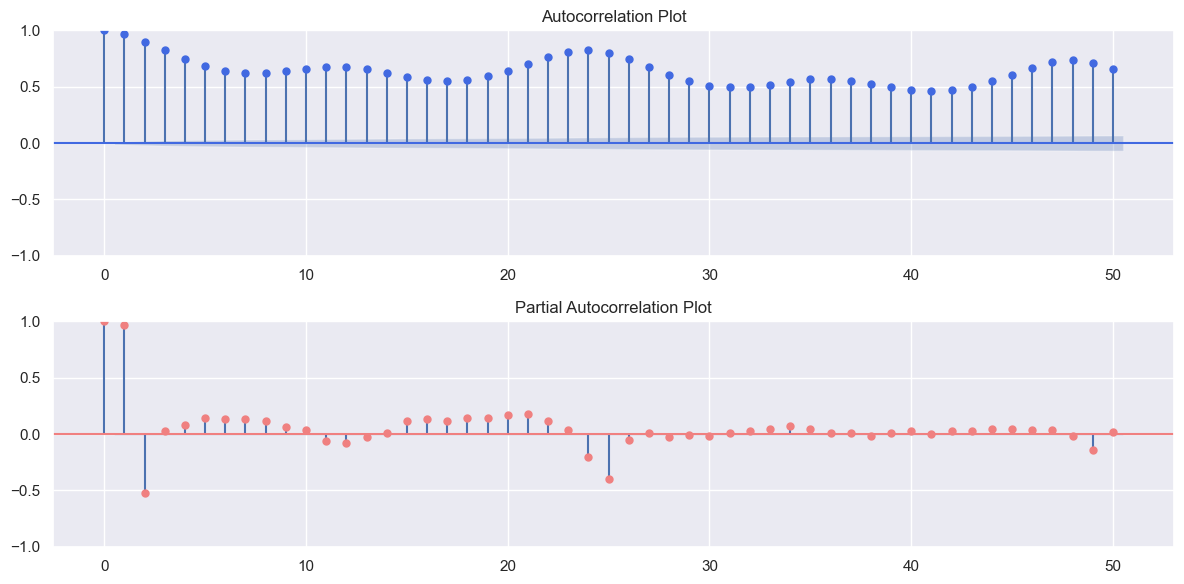

In [366]:

# Plotting the ACF and PACF of the actual electricity price to visualize how strongly the series depends on its past values, helping identify appropriate lag terms for time-series models like LSTM.
# ACF (Autocorrelation Function): Shows how much the time-series is correlated with its own past values at different lags.
# PACF (Partial Autocorrelation Function): Shows the direct correlation between the series and a past value after removing the influence of all shorter lags.

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_weather_energy['price actual'], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(df_weather_energy['price actual'], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

In [367]:
# The ACF shows high autocorrelation across many lags → the price has internal temporal patterns.
# The PACF shows only a few strong direct lag influences → these can be captured implicitly by the model.
# Thus, the ACF/PACF plots show that price actual has predictable structure over time, so we treat it as the target (y) and use all other columns as input features (X) to train a forecasting model.

X = df_weather_energy.drop(['price actual'], axis = 1)
y= df_weather_energy[['price actual']]


In [368]:

# PCA (Principal Component Analysis) is a dimensionality reduction technique that transforms many correlated features into a smaller number of new, uncorrelated features that capture most of the important information.
# This function optionally applies PCA after Min-Max scaling based on if_apply boolean.

def apply_PCA(X_input, cum_variance, if_apply):
    
    if if_apply:
    
        pca = PCA(n_components = cum_variance)
        # make pipeline to first standardize then apply PCA on data
        scaler_pca = make_pipeline(MinMaxScaler(), pca)
        X_pca = scaler_pca.fit(X_input).transform(X_input)

        return X_pca
    
    else:
        
        return np.array(X_input)

In [369]:
# Applying PCA to keep only enough principal components to explain 80% of the total variance, and X_pca.shape shows the reduced feature dimensions after compression.
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
X_pca = apply_PCA(X, **params_pca)
X_pca.shape

(35064, 15)

In [370]:
# This creates sliding time windows so that each training sample contains the past history_size steps of features (data) and the next corresponding target value (labels) for time-series prediction.
def windowing(X_input,y_input, history_size):
    
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size : i, :])
        labels.append(y_input[i])
        
    return np.array(data), np.array(labels).reshape(-1,1)

In [371]:
# Splitting the data into train/validation/test ranges and scaling the target variable y using only the training portion, then transforming the entire y series to normalized values.
train_cutoff = int(0.8*X_pca.shape[0])
val_cutoff   = int(0.9*X_pca.shape[0])

scaler_y = MinMaxScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)

In [372]:
# Converting the normalized feature–target data into sliding 24-step input windows for train, validation, and test sets so the model can learn to predict the next price from the previous 24 timesteps.
hist_size= 24
data_norm = np.concatenate((X_pca,y_norm), axis = 1)

X_train, y_train = windowing(data_norm[:train_cutoff,:],data_norm[:train_cutoff,-1], hist_size)
X_val, y_val     = windowing(data_norm[train_cutoff :val_cutoff,:],data_norm[train_cutoff:val_cutoff,-1], hist_size)
X_test, y_test   = windowing(data_norm[val_cutoff :,:],data_norm[val_cutoff:,-1], hist_size)

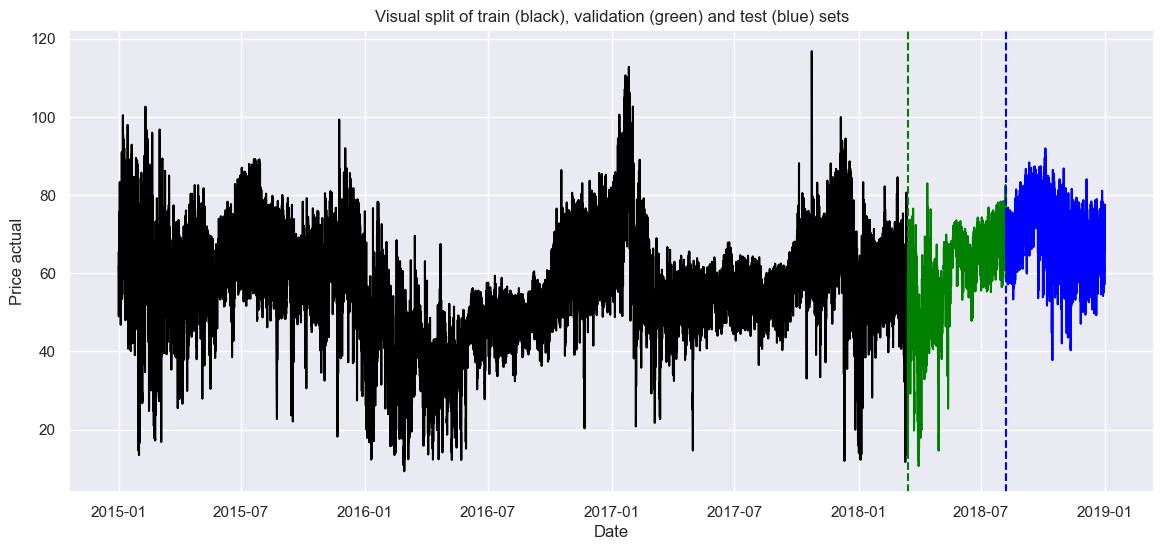

In [373]:
# Visualising how the price data is split into train (black), validation (green), and test (blue) sets.
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df_weather_energy['price actual'].iloc[:train_cutoff], color = 'black')
axes.plot(df_weather_energy['price actual'].iloc[train_cutoff + 1 : val_cutoff], color = 'green')
axes.plot(df_weather_energy['price actual'].iloc[val_cutoff + 1 :], color = 'blue')
axes.axvline(x=df_weather_energy.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=df_weather_energy.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Date')
axes.set_ylabel('Price actual')
plt.show()

# Model Training and Forecasting

<h3> 1. XGBoost </h3>
XGBoost builds many small decision trees one after another, where each new tree focuses on correcting the mistakes of the previous ones, and together they combine to make a prediction.

In [374]:
# Reshaping each time-window sample from a 2D sequence (history_size × features) into a flat 1D feature vector
def reshaping(X):
    
    reshaped_x = X.reshape(-1 , X.shape[1] * X.shape[2])
    return reshaped_x

X_train_xgb = reshaping(X_train)
X_val_xgb   = reshaping(X_val)
X_test_xgb  = reshaping(X_test)

In [ ]:
# Training using MAE (Mean Absolute Error) as the evaluation metric and early stopping based on the validation set to prevent overfitting.
# The printed parameter summary shows None because we did not manually set hyperparameters so XGBoost automatically uses its built-in default values during training/
xgb_model = xgb.XGBRegressor(
    eval_metric='mae',
    early_stopping_rounds=8
)

xgb_model.fit(
    X_train_xgb, y_train,
    eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=8,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Function to plot predicted vs actual prices and training vs validation error (MAE/loss).
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    ax[0].plot(y_pred_actual[:1000])
    ax[0].plot(y_test_inv[:1000])
    ax[0].legend(['prediction', 'actual'], loc='upper left')
    ax[0].set_title(f'Prediction vs actual price for 1000 observation in test set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')
    
    if model != 'hybrid':
    
        if model_name == 'XGBoost':

            train_mae = model.evals_result()['validation_0']['mae']
            val_mae = model.evals_result()['validation_1']['mae']
            ax[1].plot(train_mae, label='Training MAE')
            ax[1].plot(val_mae, label='Validation MAE')

        else:

            ax[1].plot(history.history['loss'], label='Training Loss')
            ax[1].plot(history.history['val_loss'], label='Validation Loss')

        ax[1].legend()
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')    
        
    fig.tight_layout()
    plt.show()
    

XGBoost MAE for test set : 0.016


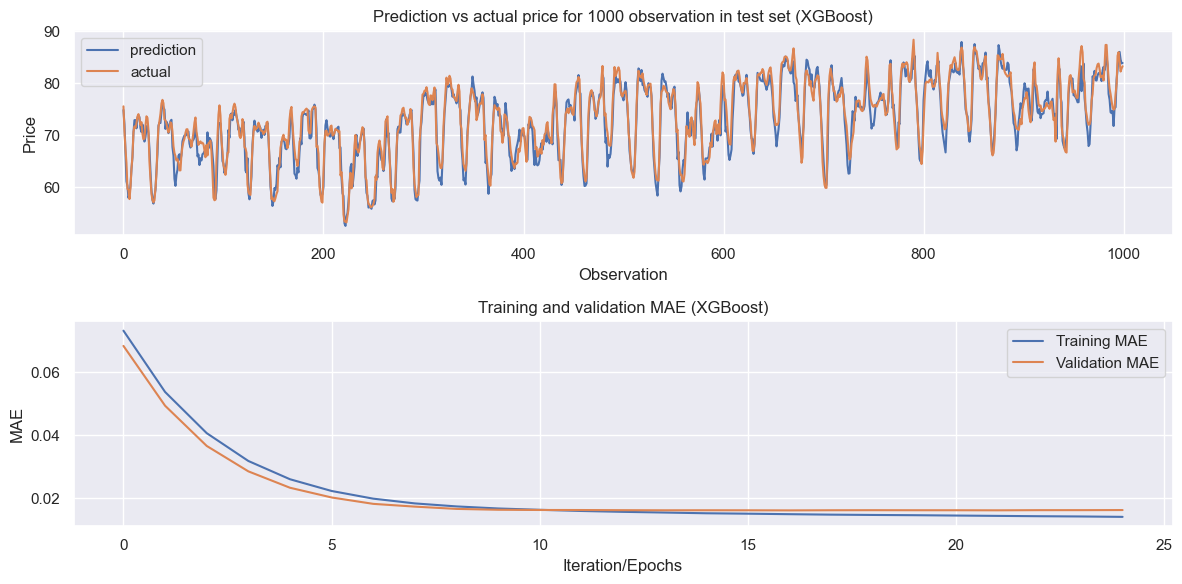

In [ ]:
# Predicting, converting values back to the original price scale, prints test MAE, and plotting.
y_pred = xgb_model.predict(X_test_xgb) 
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_test_inv = scaler_y.inverse_transform(y_test)

print(f'XGBoost MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
plot_results(y_pred_actual, y_test_inv, xgb_model,'XGBoost')

<h3> 2. GRU </h3>
GRU is a type of recurrent neural network wherein the update and reset gates learn during training which past information to keep and which to discard by adjusting their weights through backpropagation to minimize prediction error.

In [382]:
# Taking the past 24 hours of data, learning the time-based pattern using a GRU layer, then passing that learned pattern through a few dense layers to output one predicted price.
from tensorflow.keras.layers import Bidirectional, LeakyReLU

def base_model_gru():
    model = Sequential()
    model.add(Bidirectional(GRU(32, return_sequences=True), input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

gru_model = base_model_gru()

In [384]:
# Setting up training using a cyclical learning rate schedule (learning rate smoothly increases and decreases to avoid local minima), with early stopping to prevent overfitting and Adam as the optimizer.
# Adam is an improved version of gradient descent that adapts how much each weight updates, so the model learns efficiently without having to manually tune learning rates.

class CyclicLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, max_lr, step_size, scale_fn=None):
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.scale_fn = scale_fn or (lambda x: 1.0)

    def __call__(self, step):
        cycle = tf.floor(1 + step / (2 * self.step_size))
        x = tf.abs(step / self.step_size - 2 * cycle + 1)
        lr = self.initial_lr + (self.max_lr - self.initial_lr) * tf.maximum(0., (1 - x)) * self.scale_fn(cycle)
        return lr

epoch = 100
batch_size = 64
steps_per_epoch = len(X_train) // batch_size

cyclic_lr = CyclicLR(
    initial_lr=1e-4,
    max_lr=1e-2,
    step_size=6 * steps_per_epoch,
    scale_fn=lambda x: 1 / (2 ** (x - 1))
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)


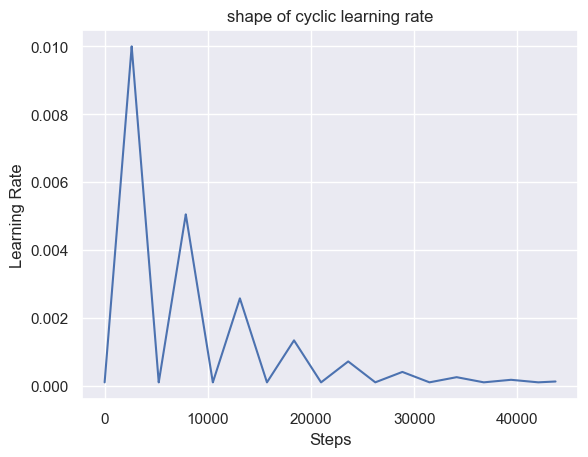

In [386]:
# Plotting how the learning rate changes over training steps under the cyclical schedule, showing the repeating rise-and-fall pattern that helps the GRU model learn more effectively.
step = np.arange(0, epoch * steps_per_epoch)
lr = cyclic_lr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("shape of cyclic learning rate")
plt.show()


In [387]:
# Compiling the GRU model using the Adam optimizer and MAE loss, then training it on the training data while monitoring validation loss and stopping early if it stops improving.
gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
history = gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 0.0684 - val_loss: 0.0377
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0391 - val_loss: 0.0360
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0321 - val_loss: 0.0263
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0298 - val_loss: 0.0195
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0260 - val_loss: 0.0254
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0238 - val_loss: 0.0246
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0234 - val_loss: 0.0152
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0213 - val_loss: 0.0166
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0196 - val_loss: 0.0154
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0185 - val_loss: 0.0150
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0173 - val_loss: 0.0155
Epoch 12/100
438/438 ━━━━

109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
GRU MAE for test set : 0.014


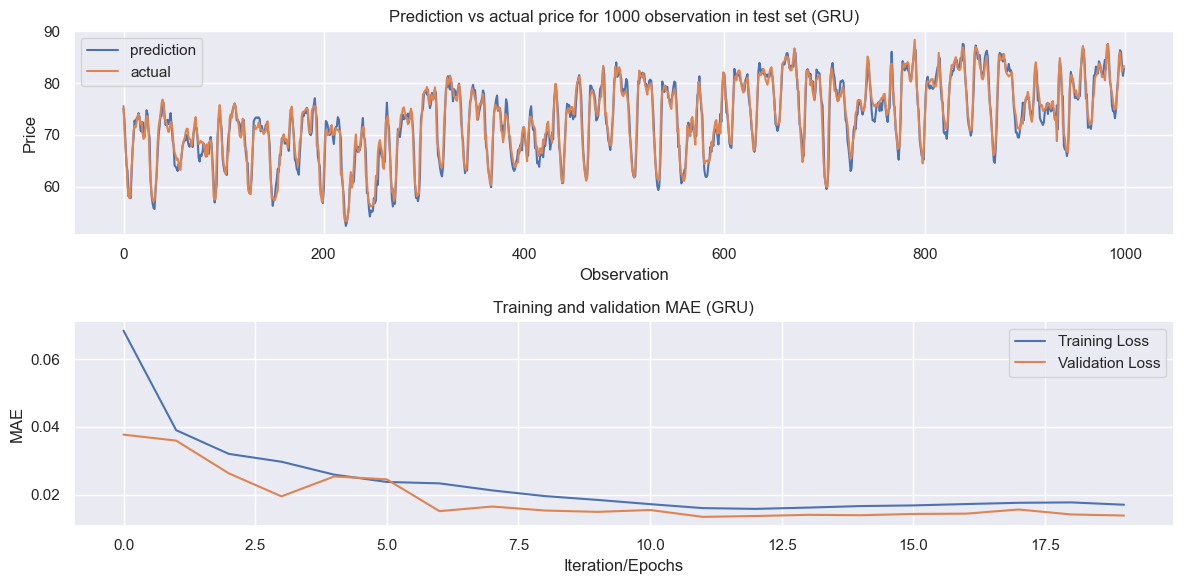

In [ ]:
# Predicting, converting values back to the original price scale, prints test MAE, and plotting. 
y_pred = gru_model.predict(X_test)
print(f'GRU MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = scaler_y.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'GRU')

<h3> 3. LSTM </h3>
Similar to GRU, LSTM is a recurrent neural network that uses three gates (input, forget, output) instead of 2 to capture slightly more complex long-term patterns.

In [389]:
# Defining an LSTM that learns patterns from the past time steps to predict the next electricity price, then compiles it using the Adam optimizer with the cyclical learning rate and MAE loss.
import tensorflow as tf

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

def base_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(1))
    return model

lstm_model = base_model_lstm()

optimizer = tf.keras.optimizers.Adam(learning_rate=cyclic_lr, amsgrad=True)

lstm_model.compile(optimizer=optimizer, loss='mean_absolute_error')

lstm_model.summary()

c:\Users\PREKSHA\miniforge3\envs\ml_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,833 (409.50 KB)

 Trainable params: 104,833 (409.50 KB)

 Non-trainable params: 0 (0.00 B)

In [393]:
# Train
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 69s 158ms/step - loss: 0.0193 - val_loss: 0.0165
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 146ms/step - loss: 0.0186 - val_loss: 0.0173
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 68s 156ms/step - loss: 0.0174 - val_loss: 0.0144
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.0166 - val_loss: 0.0136
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 49s 111ms/step - loss: 0.0163 - val_loss: 0.0134
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.0167 - val_loss: 0.0141
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 77s 177ms/step - loss: 0.0170 - val_loss: 0.0137
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 67s 153ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 63s 145ms/step - loss: 0.0178 - val_loss: 0.0170
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 71s 162ms/step - loss: 0.0180 - val_loss: 0.0146
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 64s 145ms/step - loss: 0.0181 - val_loss: 0.0161
Epoch 12

109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step
LSTM MAE for test set : 0.014


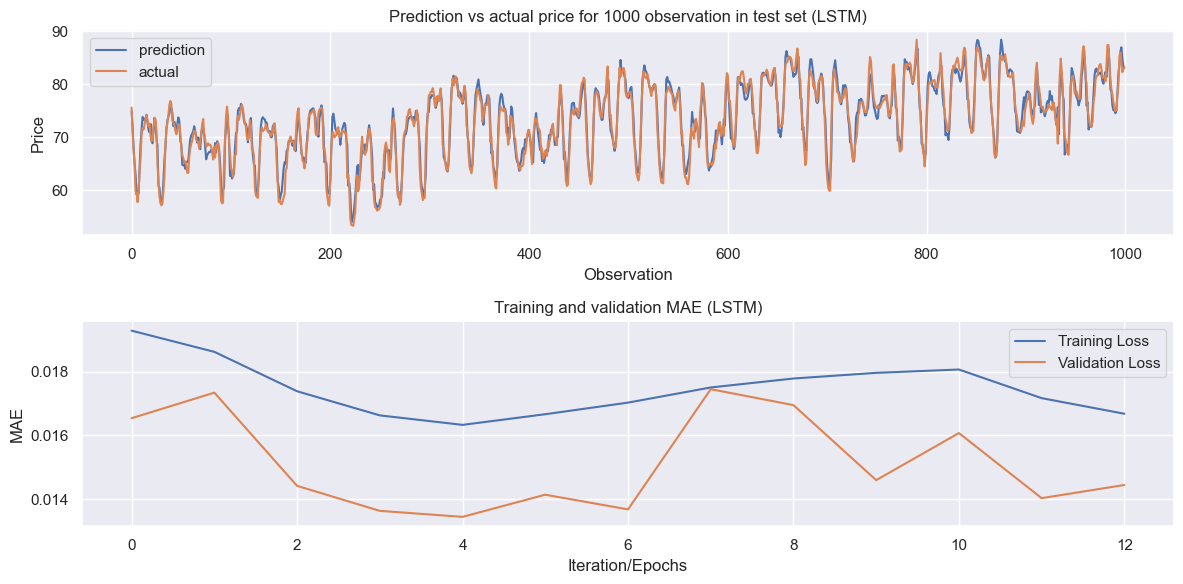

In [394]:
# Predicting, converting values back to the original price scale, prints test MAE, and plotting.
y_pred = lstm_model.predict(X_test)
print(f'LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = scaler_y.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

<h3> 4. CNN </h3>
CNN learns patterns by sliding filters across the time series to detect short-term local trends (like spikes or dips), making it good at capturing shape-based patterns in the data.

In [395]:
# Defing 1D-CNN model that uses convolution to learn short-term patterns in the past time steps, flattens the output, and maps it through dense layers to predict the next electricity price, then compiles it with the Adam optimizer and MAE loss.
def base_model_cnn():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

cnn_model = base_model_cnn()

optimizer_cnn = tf.keras.optimizers.Adam(learning_rate=cyclic_lr, amsgrad=True)

cnn_model.compile(optimizer=optimizer_cnn, loss='mean_absolute_error')

cnn_model.summary()

c:\Users\PREKSHA\miniforge3\envs\ml_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        90,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,937 (359.13 KB)

 Trainable params: 91,937 (359.13 KB)

 Non-trainable params: 0 (0.00 B)

In [396]:
# Train
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - loss: 0.0797 - val_loss: 0.0562
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 0.0435 - val_loss: 0.0351
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 0.0361 - val_loss: 0.0496
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 0.0320 - val_loss: 0.0394
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - loss: 0.0303 - val_loss: 0.0252
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - loss: 0.0311 - val_loss: 0.0262
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - loss: 0.0283 - val_loss: 0.0215
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - loss: 0.0261 - val_loss: 0.0300


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
CNN MAE for test set : 0.032


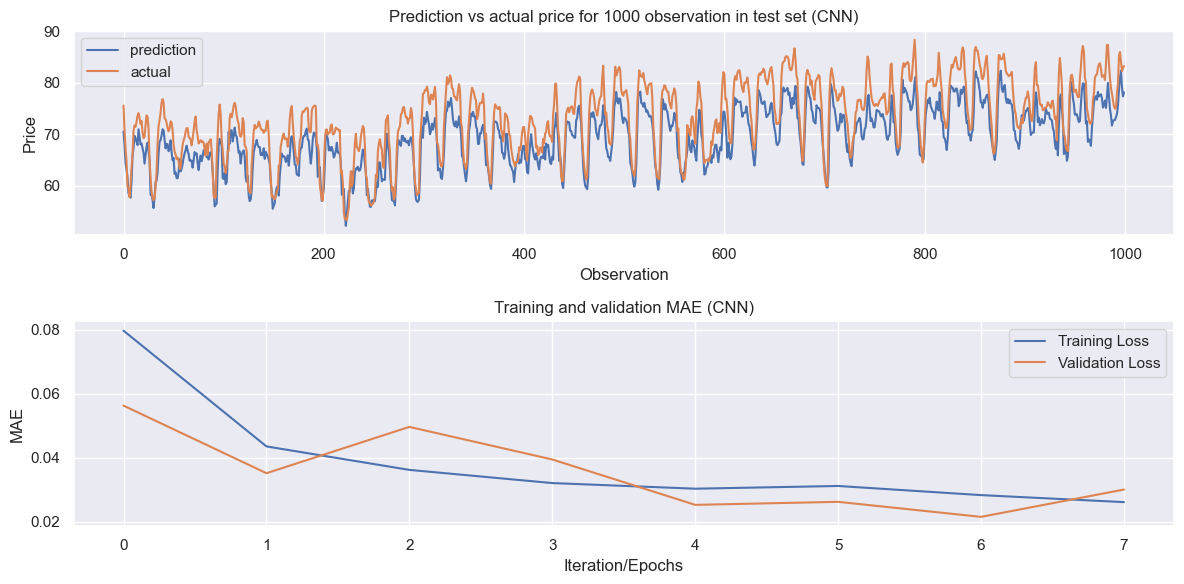

In [397]:
# Predicting, converting values back to the original price scale, prints test MAE, and plotting.
y_pred = cnn_model.predict(X_test)
print(f'CNN MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = scaler_y.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'CNN')

<h3> 5. CNN-LSTM </h3>
This model first uses a CNN layer to extract short-term local patterns from the time window, then a LSTM layer to learn longer-term temporal dependencies, and finally dense layers to output the next predicted electricity price.

In [398]:
def base_model_cnn_lstm():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
    model.add(LSTM(units=8, return_sequences=True, activation="relu"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    return model

optimizer_cnn_lstm = tf.keras.optimizers.Adam(learning_rate=cyclic_lr, amsgrad=True)

cnn_lstm_model = base_model_cnn_lstm()
cnn_lstm_model.compile(optimizer=optimizer_cnn_lstm, loss='mean_absolute_error')
cnn_lstm_model.summary()

c:\Users\PREKSHA\miniforge3\envs\ml_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 22, 64)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 22, 8)          │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 176)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        45,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,041 (199.38 KB)

 Trainable params: 51,041 (199.38 KB)

 Non-trainable params: 0 (0.00 B)

In [399]:
# Train
history = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 74s 169ms/step - loss: 0.0737 - val_loss: 0.0576
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 46s 106ms/step - loss: 0.0395 - val_loss: 0.0402
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - loss: 0.0336 - val_loss: 0.0384
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 49s 112ms/step - loss: 0.0306 - val_loss: 0.0308
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 908s 2s/step - loss: 0.0282 - val_loss: 0.0228
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - loss: 0.0275 - val_loss: 0.0226
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 74s 169ms/step - loss: 0.0243 - val_loss: 0.0218
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 79s 181ms/step - loss: 0.0221 - val_loss: 0.0229


109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step
CNN-LSTM MAE for test set : 0.022


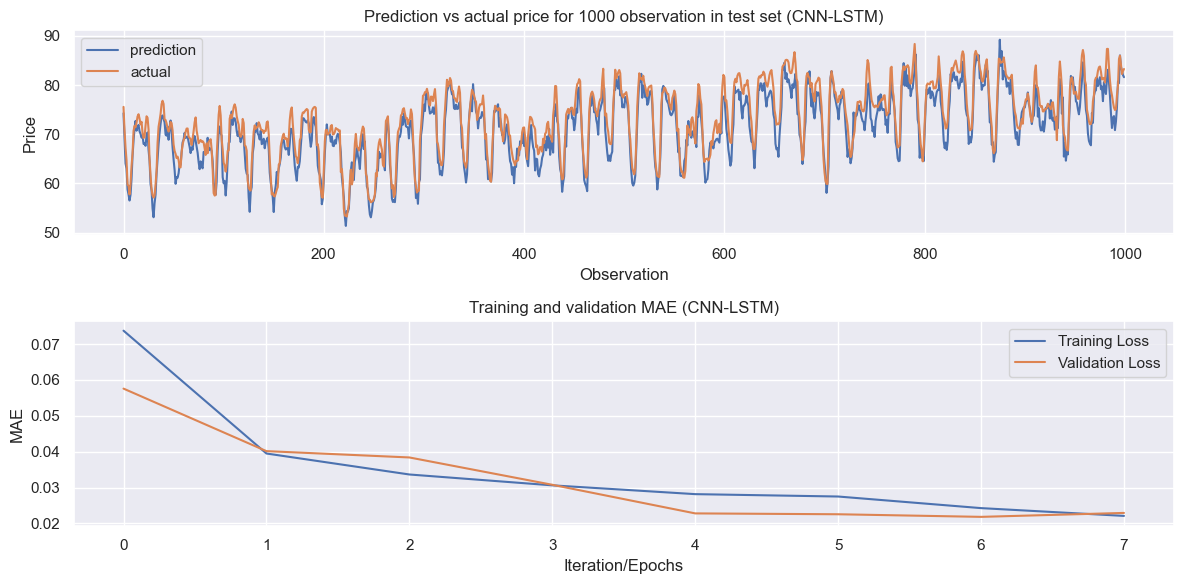

In [400]:
# Predicting, converting values back to the original price scale, prints test MAE, and plotting.
y_pred = cnn_lstm_model.predict(X_test)
print(f'CNN-LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = scaler_y.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'CNN-LSTM')

<h3> 6. LSTM-Attention </h3>
The LSTM-Attention model computes a learnable weight for each time step (via a small Dense layer + softmax), then multiplies those weights with the LSTM outputs so that more important past moments contribute more.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Masking, Flatten, Activation,
    Multiply, Lambda, RepeatVector, Permute
)
from tensorflow.keras.models import Model

def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
    masked = Masking(mask_value=0.)(inputs)
    lstm_out = LSTM(128, return_sequences=True)(masked)

    attention = Dense(1, activation='tanh')(lstm_out)  # learnable attention weights
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)        # normalize over timesteps
    attention = RepeatVector(128)(attention)            # repeat for feature dimension
    attention = Permute([2, 1])(attention)              # align for multiplication

    context = Multiply()([lstm_out, attention])         # apply attention weights
    context = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context)  # weighted sum

    output = Dense(1)(context)
    model = Model(inputs, outputs=output)
    return model


optimizer_new = tf.keras.optimizers.Adam(learning_rate=cyclic_lr, amsgrad=True)

LSTM_attention_model = LSTM_attention()
LSTM_attention_model.compile(optimizer=optimizer_new, loss='mae')
LSTM_attention_model.summary()


c:\Users\PREKSHA\miniforge3\envs\ml_env\lib\site-packages\keras\src\layers\layer.py:970: UserWarning:

Layer 'flatten_5' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 24, 16)    │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 24, 16)    │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 24)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 128)   │     74,240 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 24, 1)     │        129 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 24)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 24)        │          0 │ flatten_5[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 24)   │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 24, 128)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 24, 128)   │          0 │ lstm_2[0][0],     │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 74,498 (291.01 KB)

 Trainable params: 74,498 (291.01 KB)

 Non-trainable params: 0 (0.00 B)

In [402]:
# Train
history = LSTM_attention_model.fit(
    X_train, y_train,
    epochs=epoch,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)


Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 104s 238ms/step - loss: 0.0749 - val_loss: 0.0456
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 134s 305ms/step - loss: 0.0424 - val_loss: 0.0366
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 142s 323ms/step - loss: 0.0373 - val_loss: 0.0337
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 131s 299ms/step - loss: 0.0336 - val_loss: 0.0386
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 119s 271ms/step - loss: 0.0291 - val_loss: 0.0269
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 121s 275ms/step - loss: 0.0256 - val_loss: 0.0238
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 113s 259ms/step - loss: 0.0216 - val_loss: 0.0168
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 93s 213ms/step - loss: 0.0188 - val_loss: 0.0155


  4/109 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step

c:\Users\PREKSHA\miniforge3\envs\ml_env\lib\site-packages\keras\src\layers\layer.py:970: UserWarning:

Layer 'flatten_5' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step
LSTM-Attention MAE for test set : 0.017


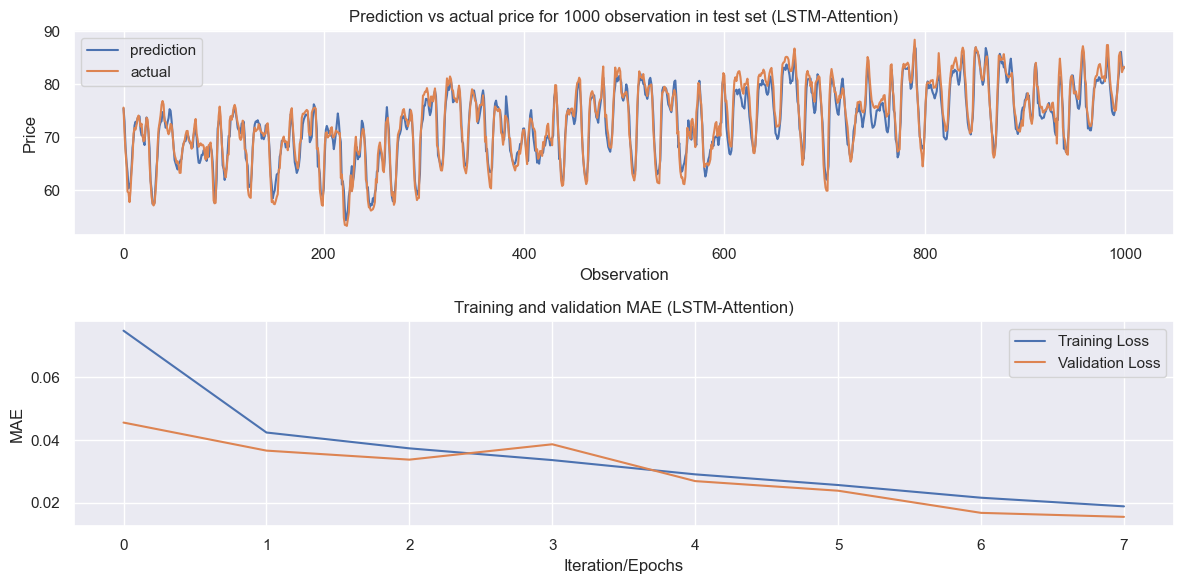

In [403]:
# Predicting, converting values back to the original price scale, prints test MAE, and plotting.
y_pred = LSTM_attention_model.predict(X_test)
print(f'LSTM-Attention MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
y_pred_actual = scaler_y.inverse_transform(y_pred)
plot_results(y_pred_actual, y_test_inv, history,'LSTM-Attention')

<h3> 7. Hybrid GRU-XGBoost </h3>
The GRU–XGBoost hybrid first uses a GRU to make the price prediction, then trains XGBoost on the GRU’s errors (residuals) to model non-linear patterns the GRU missed.

In [404]:
def base_model_bigru():
    model = Sequential()
    model.add(Input(shape=X_train.shape[-2:]))
    model.add(GRU(units=32, return_sequences=True, activation="relu"))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model


optimizer_gru = tf.keras.optimizers.Adam(learning_rate=cyclic_lr, amsgrad=True)

def weighted_mae(y_true, y_pred):
    weights = tf.where(y_true > tf.reduce_mean(y_true), 1.2, 1.0)
    return tf.reduce_mean(weights * tf.abs(y_true - y_pred))

gru_model = base_model_gru()
gru_model.compile(optimizer=optimizer_gru, loss=weighted_mae)


print("\nTraining BiGRU-EnergyForecaster...\n")

history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback],
    verbose=1
)

y_train_pred = gru_model.predict(X_train)
y_val_pred   = gru_model.predict(X_val)

residuals_train = y_train.flatten() - y_train_pred.flatten()
residuals_val   = y_val.flatten()   - y_val_pred.flatten()


print("\nTraining XGBoost residual corrector...\n")
xgb_correction = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)
xgb_correction.fit(X_train_xgb, residuals_train)

c:\Users\PREKSHA\miniforge3\envs\ml_env\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

c:\Users\PREKSHA\miniforge3\envs\ml_env\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning:

Argument `alpha` is deprecated. Use `negative_slope` instead.




Training BiGRU-EnergyForecaster...

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 141s 320ms/step - loss: 0.0795 - val_loss: 0.0475
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 133s 303ms/step - loss: 0.0440 - val_loss: 0.0340
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 131s 299ms/step - loss: 0.0353 - val_loss: 0.0265
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 144s 329ms/step - loss: 0.0322 - val_loss: 0.0490
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 132s 301ms/step - loss: 0.0291 - val_loss: 0.0285
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 273s 624ms/step - loss: 0.0275 - val_loss: 0.0201
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 220s 502ms/step - loss: 0.0255 - val_loss: 0.0321
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 190s 433ms/step - loss: 0.0232 - val_loss: 0.0172
876/876 ━━━━━━━━━━━━━━━━━━━━ 234s 268ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 260ms/step

Training XGBoost residual corrector...



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

109/109 ━━━━━━━━━━━━━━━━━━━━ 33s 300ms/step
Hybrid BiGRU-XGBoost MAE for test set: 0.015


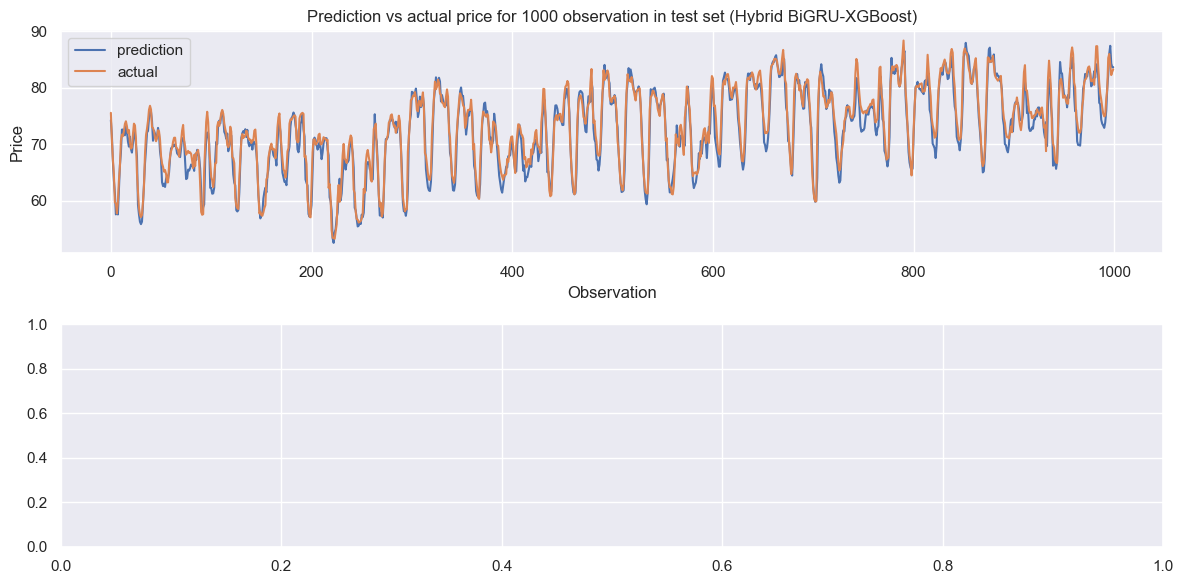

In [405]:
# Generating the final hybrid prediction by adding the GRU forecast and the XGBoost-predicted residual correction, converting it back to the real price scale, reporting the MAE, and plotting.
y_pred_gru = gru_model.predict(X_test)
residual_pred = xgb_correction.predict(X_test_xgb)
y_pred_hybrid = y_pred_gru.flatten() + residual_pred

y_pred_actual = scaler_y.inverse_transform(y_pred_hybrid.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test)

print(f"Hybrid BiGRU-XGBoost MAE for test set: {round(mean_absolute_error(y_pred_hybrid, y_test.flatten()), 3)}")

plot_results(y_pred_actual, y_test_inv, 'hybrid', 'Hybrid BiGRU-XGBoost')

<h3> 8. Hybrid LSTM-Attention-XGBoost </h3>
The LSTM first learns the temporal patterns by remembering important information across time steps. The attention mechanism then highlights and assigns greater weight to the time steps that are most relevant for predicting the next price. Finally, XGBoost is trained on the LSTM’s residual errors to capture any remaining nonlinear relationships the LSTM did not fully learn, and the correction it provides is added back to the LSTM’s prediction for a more accurate overall forecast.

In [406]:
def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
    # Mask zeros to handle missing values
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)

    # Self-attention
    attention = dot([lstm, lstm], axes=[2, 2])
    attention = Dense(hist_size, activation='softmax')(attention)
    context = dot([attention, lstm], axes=[2, 1])

    flattened = Flatten()(context)
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)
    return model


optimizer_lstm_att = tf.keras.optimizers.Adam(learning_rate=cyclic_lr, amsgrad=True)

LSTM_attention_model = LSTM_attention()
LSTM_attention_model.compile(optimizer=optimizer_lstm_att, loss='mae')

print('\nLSTM-Attention is fitting a model on train-validation sets...\n')

LSTM_attention_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

print('LSTM-Attention is predicting...\n')

# Compute residuals
residuals_train = y_train - LSTM_attention_model.predict(X_train)
residuals_val   = y_val - LSTM_attention_model.predict(X_val)

print('XGBoost is fitting a model on residuals...\n')

xgb_hybrid_lstmatt = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    eval_metric='mae',          
    early_stopping_rounds=8,    
    random_state=42
)

xgb_hybrid_lstmatt.fit(
    X_train_xgb, residuals_train,
    eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],
    verbose=False
)


y_train_pred = LSTM_attention_model.predict(X_train) + xgb_hybrid_lstmatt.predict(X_train_xgb).reshape(-1, 1)
y_val_pred   = LSTM_attention_model.predict(X_val)   + xgb_hybrid_lstmatt.predict(X_val_xgb).reshape(-1, 1)



LSTM-Attention is fitting a model on train-validation sets...

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 169s 385ms/step - loss: 0.0643 - val_loss: 0.0613
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 109s 249ms/step - loss: 0.0386 - val_loss: 0.0308
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 101s 230ms/step - loss: 0.0316 - val_loss: 0.0215
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 144s 330ms/step - loss: 0.0250 - val_loss: 0.0194
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 123s 281ms/step - loss: 0.0239 - val_loss: 0.0274
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 254ms/step - loss: 0.0232 - val_loss: 0.0207
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 105s 239ms/step - loss: 0.0217 - val_loss: 0.0176
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 103s 236ms/step - loss: 0.0198 - val_loss: 0.0156
LSTM-Attention is predicting...

876/876 ━━━━━━━━━━━━━━━━━━━━ 87s 99ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step
XGBoost is fitting a model on residuals...

876/876 ━━━━━━━━━━━━━━━━━━━━ 91s 104ms/step
1

109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step
LSTM-Attention-XGBoost MAE for test set : 0.014



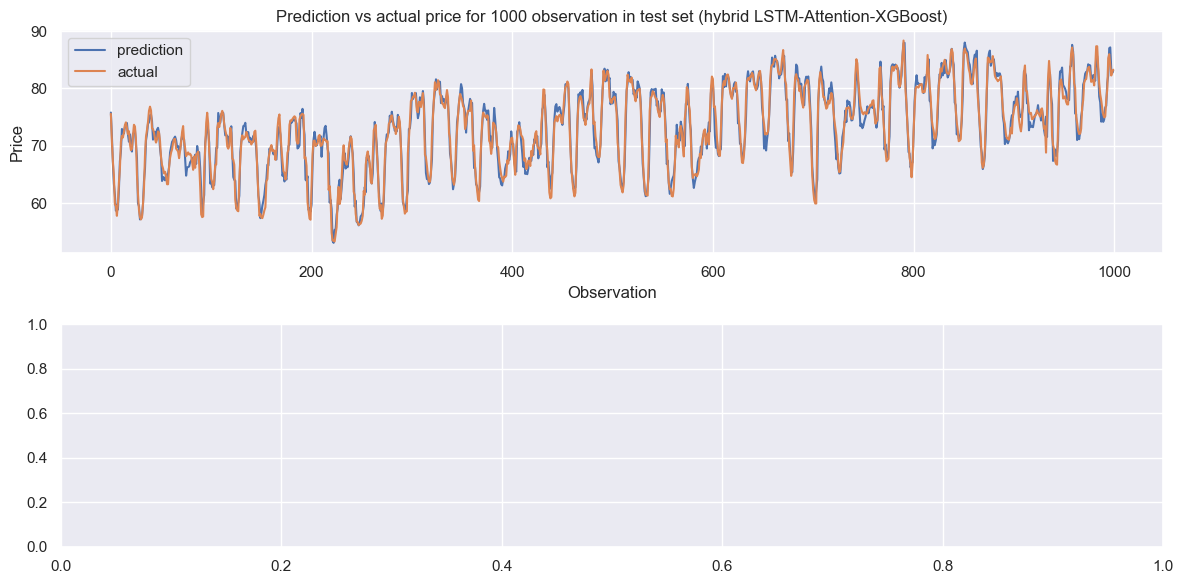

In [407]:
# Predicting, converting values back to the original price scale, prints test MAE, and plotting.
y_test_pred  = LSTM_attention_model.predict(X_test) + xgb_hybrid_lstmatt.predict(X_test_xgb).reshape(-1,1)
print(f'LSTM-Attention-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid LSTM-Attention-XGBoost')

<h3> Evaluating MAE for All Models </h3>

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_results = {}

# Baseline: TSO Prediction
mae_results["TSO prediction"] = round(mean_absolute_error(actual_norm[val_cutoff:], dayahead_norm[val_cutoff:]), 3)

# XGBoost
mae_results["XGBoost"] = round(mean_absolute_error(y_test, xgb_model.predict(X_test_xgb)), 3)

# GRU
mae_results["GRU"] = round(mean_absolute_error(y_test, gru_model.predict(X_test)), 3)

# LSTM
mae_results["LSTM"] = round(mean_absolute_error(y_test, lstm_model.predict(X_test)), 3)

# CNN
mae_results["CNN"] = round(mean_absolute_error(y_test, cnn_model.predict(X_test)), 3)

# CNN-LSTM
mae_results["CNN-LSTM"] = round(mean_absolute_error(y_test, cnn_lstm_model.predict(X_test)), 3)

# LSTM-Attention
mae_results["LSTM-Attention"] = round(mean_absolute_error(y_test, LSTM_attention_model.predict(X_test)), 3)

# Hybrid GRU-XGBoost
mae_results["Hybrid GRU-XGBoost"] = round(mean_absolute_error(y_test, y_pred_hybrid.reshape(-1,1)), 3)

# Hybrid LSTM-Attention-XGBoost
residual_pred_test = xgb_hybrid_lstmatt.predict(X_test_xgb)
y_pred_lstmatt_hybrid = LSTM_attention_model.predict(X_test).flatten() + residual_pred_test
mae_results["Hybrid LSTM-Attention-XGBoost"] = round(mean_absolute_error(y_test.flatten(), y_pred_lstmatt_hybrid), 3)

# Display
print("\n=== Mean Absolute Error (MAE) Results ===")
for model, mae_val in mae_results.items():
    print(f"{model:<35}: {mae_val}")


109/109 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step

=== Mean Absolute Error (MAE) Results ===
TSO prediction                     : 0.078
XGBoost                            : 0.016
GRU                                : 0.026
LSTM                               : 0.014
CNN                                : 0.032
CNN-LSTM                           : 0.022
LSTM-Attention                     : 0.016
Hybrid GRU-XGBoost                 : 0.015
Hybrid LSTM-Attention-XGBoost      : 0.014
